<a href="https://colab.research.google.com/github/Skeo220/time-series-deep-learning-EUR-USD/blob/main/Forex_Predictions_using_ARIMA_and_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I've made some significant progress with the data analysis, and I have a couple of thoughts moving forward:

1. Shorten Prediction Horizon: Let's consider narrowing our prediction horizon. We can focus on forecasting for one to 2 week, which should allow us to fine-tune our models and improve accuracy. This shorter horizon may also reduce the amount of training data required. I also have not explored adding extra variables to these models

2. Exploring Deep Learning: I'm eager to delve into deep learning models to see if they can provide better results. That's where I'll be directing my efforts due to the non-linear trend present in the data.

Feel free to explore and build upon the work we've done so far. We've laid the groundwork, and with collaborative effort, we can make even more progress. Let's keep up the good work

In [ ]:
# importing the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import mean_absolute_error, mean_squared_error

We will just be using date and the forex close rate to make the forecast

# Importing the data

In [ ]:
# setting the time period
start_date = '2015-01-01'
end_date = '2023-09-01'

In [ ]:
# setting the currency pair
forex_pair = 'EURUSD=X'

In [ ]:
# downloading the data
df = yf.download(forex_pair, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# inspecting the data
df.shape

(2258, 6)

In [ ]:
# keeping the date and the close rate
df = df['Close']

In [ ]:
# saving the data to csv
data = 'eurusd.csv'
df.to_csv(data, index=True)

In [ ]:
# reading the csv file
df = pd.read_csv('/content/eurusd.csv')

In [ ]:
# viewing the data
df.head()

,Date,Close
0,2015-01-01,1.209863
1,2015-01-02,1.208941
2,2015-01-05,1.194643
3,2015-01-06,1.193902
4,2015-01-07,1.187536


In [ ]:
# Setting date as the index
df.set_index('Date', inplace=True, drop=True)

# transforming date into a datetime object
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-12',
               '2015-01-13', '2015-01-14',
               ...
               '2023-08-18', '2023-08-21', '2023-08-22', '2023-08-23',
               '2023-08-24', '2023-08-25', '2023-08-28', '2023-08-29',
               '2023-08-30', '2023-08-31'],
              dtype='datetime64[ns]', name='Date', length=2258, freq=None)

In [ ]:
# checking the type of the other column
df.dtypes

Close    float64
dtype: object

In [ ]:
# viewing the new dataset
df.head()

,Close
Date,
2015-01-01,1.209863
2015-01-02,1.208941
2015-01-05,1.194643
2015-01-06,1.193902
2015-01-07,1.187536


Let's split our dataset into a train and test before moving further.

In [ ]:
# splitting the dataset between training and testing
train = df[df.index.year <= 2022]
test = df[df.index.year > 2022]

In [ ]:
# train set
train.tail()

,Close
Date,
2022-12-26,1.066780
2022-12-27,1.064022
2022-12-28,1.063717
2022-12-29,1.062925
2022-12-30,1.066075


In [ ]:
# test set
test.head()

,Close
Date,
2023-01-02,1.070973
2023-01-03,1.067771
2023-01-04,1.054685
2023-01-05,1.060637
2023-01-06,1.052222


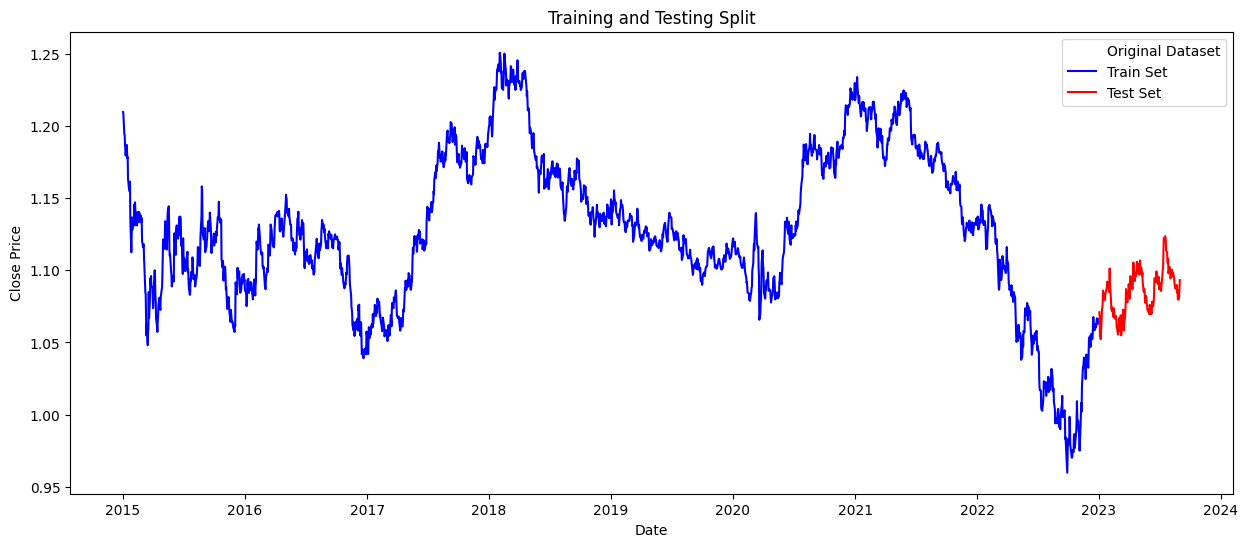

In [ ]:
# visualizing the split
# plotting the entire series
plt.figure(figsize=(15,6))
plt.plot(df.index, df['Close'], label='Original Dataset', color='blue', alpha=0)

# highlighting the training and testing sets
plt.plot(train.index, train['Close'], label='Train Set', color='blue', alpha=1)
plt.plot(test.index, test['Close'], label='Test Set', color='red', alpha=1)

# labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Training and Testing Split')
plt.legend()
plt.show()

## 1. Analyzing the components



Visualizing the components of a time series is called *Decomposition*. It is a statistical process that separates a time series into different components. In this next step, we are going to analyze the different components of our data.

<Axes: xlabel='Date'>

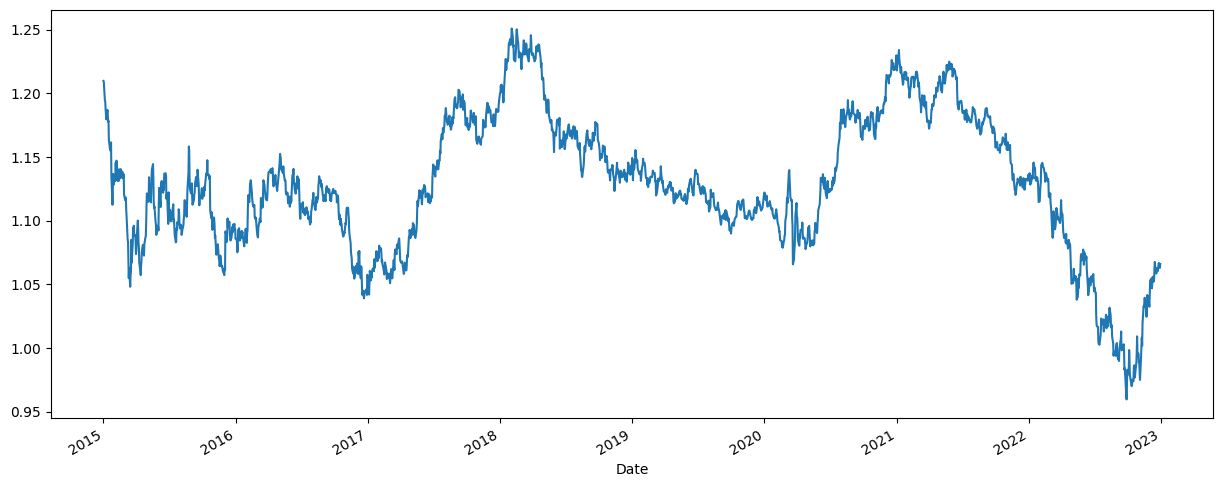

In [ ]:
# let's visualize the dataset
train['Close'].plot(kind='line', figsize=(15,6))

In [ ]:
# decomposing the dataset
advanced_decomposition = STL(df['Close'], period=4).fit()

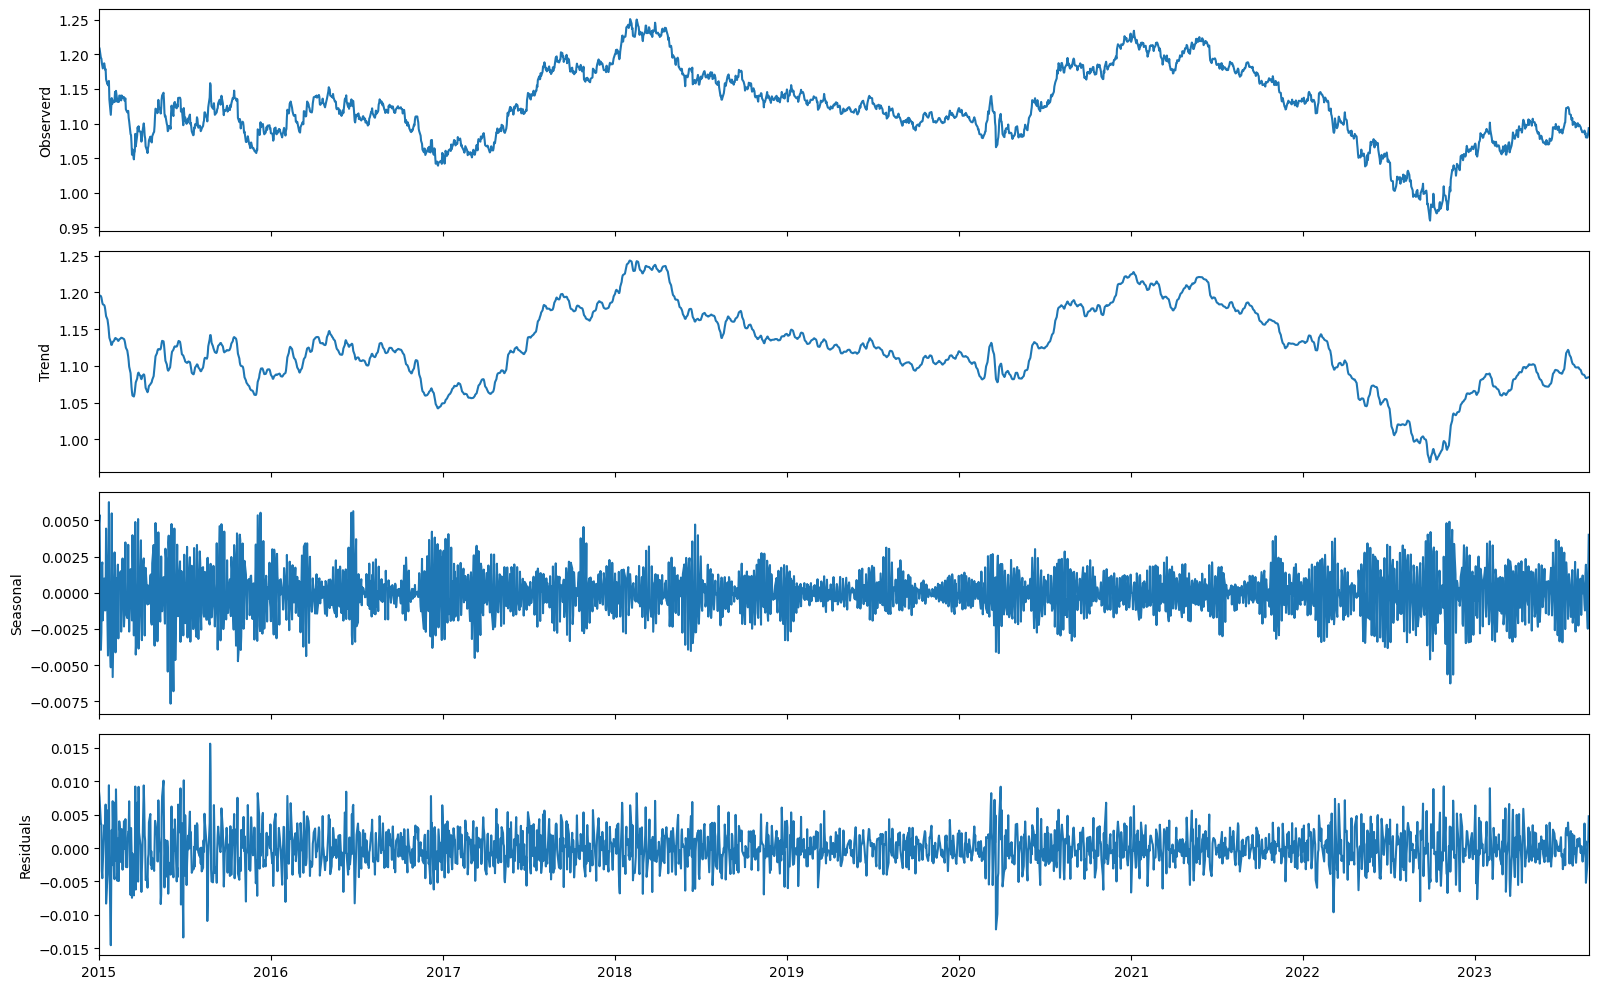

In [ ]:
# viewing the decomposed elements
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(16,10))

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observerd')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlim(df.index[0], df.index[-1])

plt.tight_layout()

1. The trend closely follows the shape of the original dataset
2. The seasonal trend shows how we deviate from the trend. The seasonal range is very low.
3. There is a little bit of variation that can not be explained by the trend or the seasonality.

## Developing Base Line Models

### Developing forecasts using the historical mean

In [ ]:
# getting the historical mean of the data
historical_mean = np.mean(train['Close'])
historical_mean

1.128385139718623

In [ ]:
test.tail()

,Close
Date,
2023-08-25,1.079914
2023-08-28,1.079739
2023-08-29,1.082556
2023-08-30,1.086921
2023-08-31,1.093255


In [ ]:
# adding the historical mean to the test data as a prediction
test.loc[:, 'pred_hist_mean'] = historical_mean
test.tail()

<ipython-input-23-2f32408ea42e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_hist_mean'] = historical_mean


,Close,pred_hist_mean
Date,,
2023-08-25,1.079914,1.128385
2023-08-28,1.079739,1.128385
2023-08-29,1.082556,1.128385
2023-08-30,1.086921,1.128385
2023-08-31,1.093255,1.128385


In [ ]:
# creating a function to compute the mean absolute percentage error
def calculate_mape(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) for a set of actual and predicted values.

    Parameters:
    y_true (array-like): Array of actual (true) values.
    y_pred (array-like): Array of predicted values.

    Returns:
    mape (float): Mean Absolute Percentage Error as a percentage.

    Notes:
    MAPE measures the average percentage difference between actual and predicted values.
    It is expressed as a percentage and is a common metric for assessing the accuracy of predictions.
    A lower MAPE indicates better prediction accuracy. MAPE is sensitive to percentage errors,
    making it suitable for assessing predictions in scenarios with varying scales.
    """
    mape = 100 * np.mean(np.abs((y_true - y_pred) / y_true))
    return mape

In [ ]:
# calculating mape
mape_hist_mean = calculate_mape(test['Close'], test['pred_hist_mean'])
mape_hist_mean

3.9739076354730485

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(pred_col):
    """
    Plot predictions and test data with a zoomed-in view.

    Parameters:
    pred_col (str): Name of the predicted column in the test data.

    Returns:
    None
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot the entire prediction and test data
    ax1.plot(train.index, train['Close'], color='blue', label='Train')
    ax1.plot(test.index, test['Close'], color='green', label='Test')
    ax1.plot(test.index, test[pred_col], color='red', label='Predicted')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('EUR/USD rates')
    ax1.set_title('Full View')
    ax1.legend()

    # Plot a zoomed-in view of the prediction and test data
    ax2.plot(test.index, test['Close'], color='green', label='Test')
    ax2.plot(test.index, test[pred_col], color='red', label='Predicted')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('EUR/USD rates')
    ax2.set_title('Zoomed In')
    ax2.legend()

    plt.tight_layout()
    plt.show()

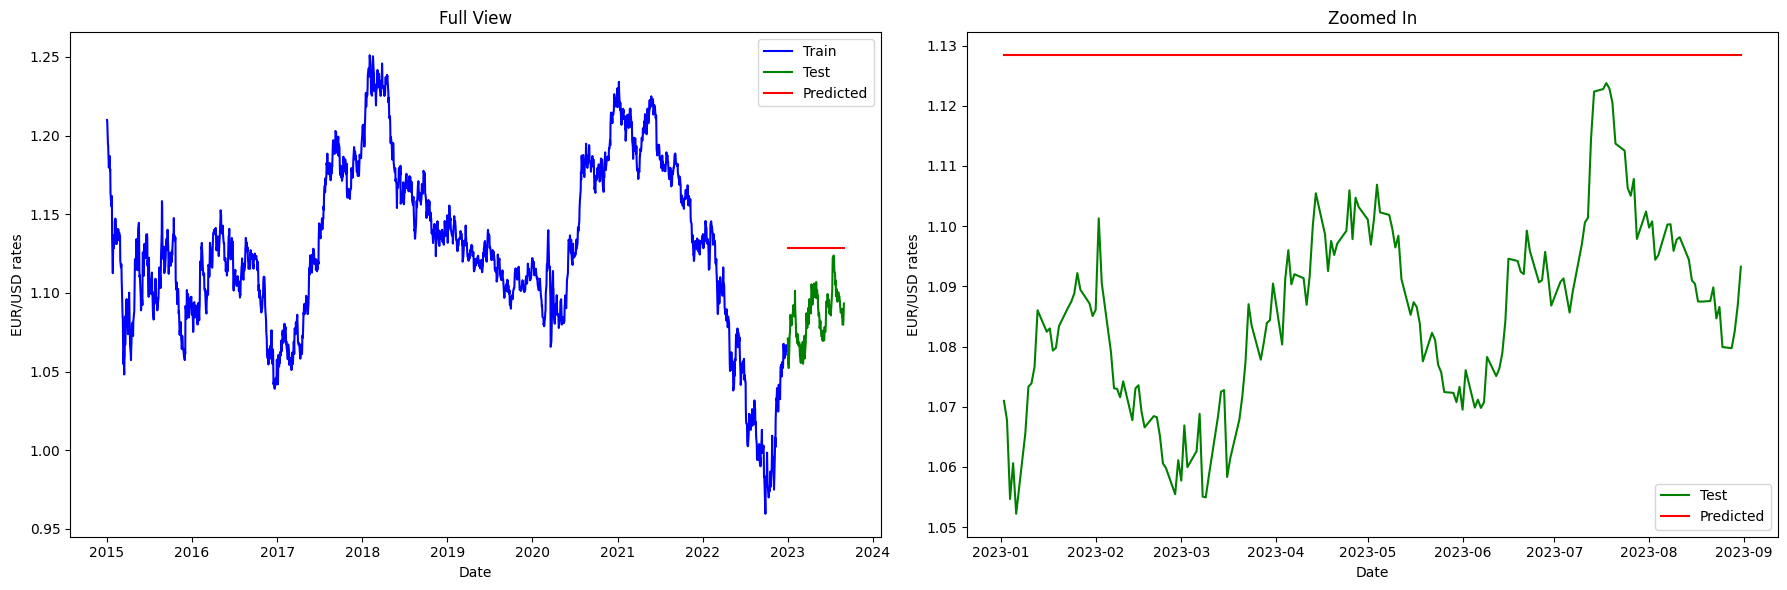

In [ ]:
fig = plot_predictions('pred_hist_mean')
plt.show()

### Developping forecasts using the previous year's mean

In [ ]:
# Getting last year's date
last_year_date = np.max(train.index) - np.timedelta64(1, 'Y')
# last_year_date

# previous year's data
last_year_data = train[train.index >= last_year_date]
# last_year_data.tail()

# previous year's mean
last_year_mean = last_year_data['Close'].mean()
last_year_mean


1.0542691352258202

In [ ]:
# appending last year's mean to the data
test.loc[:, 'pred_last_year_mean'] = last_year_mean
test.tail()

<ipython-input-29-989ec345a7f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_year_mean'] = last_year_mean


,Close,pred_hist_mean,pred_last_year_mean
Date,,,
2023-08-25,1.079914,1.128385,1.054269
2023-08-28,1.079739,1.128385,1.054269
2023-08-29,1.082556,1.128385,1.054269
2023-08-30,1.086921,1.128385,1.054269
2023-08-31,1.093255,1.128385,1.054269


In [ ]:
mape_last_year_mean = calculate_mape(test['Close'], test['pred_last_year_mean'])
mape_last_year_mean

2.857673143602426

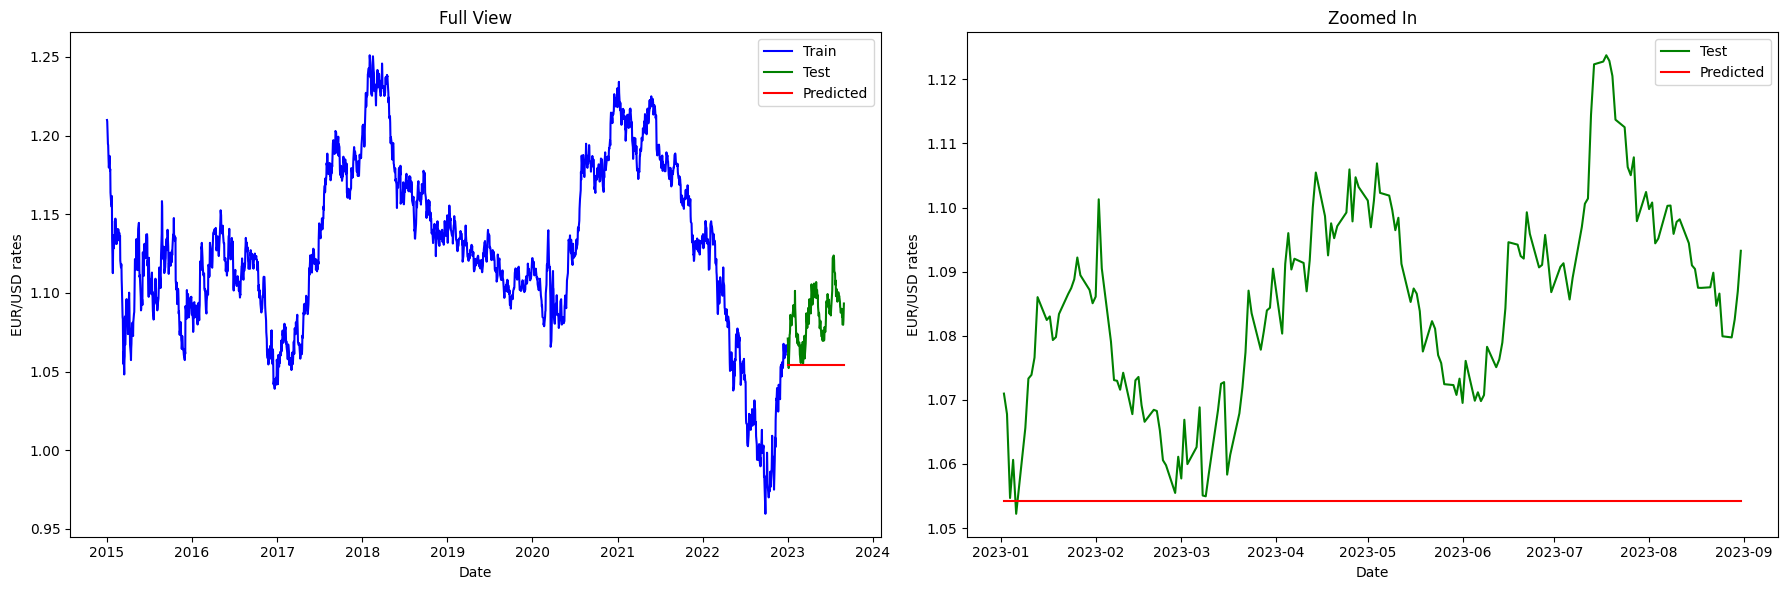

In [ ]:
# plotting the predictions
plot_predictions('pred_last_year_mean')

### Developing forecasts using last 6 months mean

In [ ]:
# Getting the 6 month time interval
last_six_date = np.max(train.index) - np.timedelta64(6, 'M')
# past_six_date

# previous year's data
last_six_data = train[train.index >= last_six_date]
# past_six_data.tail()

# previous year's mean
pred_last_six_mean = last_six_data['Close'].mean()
pred_last_six_mean

1.014222076375976

In [ ]:
# appending the past 6 month's mean to the data
test.loc[:, 'pred_last_six_mean'] = pred_last_six_mean
test.tail()

<ipython-input-33-41bb58aa97e9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_six_mean'] = pred_last_six_mean


,Close,pred_hist_mean,pred_last_year_mean,pred_last_six_mean
Date,,,,
2023-08-25,1.079914,1.128385,1.054269,1.014222
2023-08-28,1.079739,1.128385,1.054269,1.014222
2023-08-29,1.082556,1.128385,1.054269,1.014222
2023-08-30,1.086921,1.128385,1.054269,1.014222
2023-08-31,1.093255,1.128385,1.054269,1.014222


In [ ]:
mape_last_year_mean = calculate_mape(test['Close'], test['pred_last_six_mean'])
mape_last_year_mean

6.545532390412954

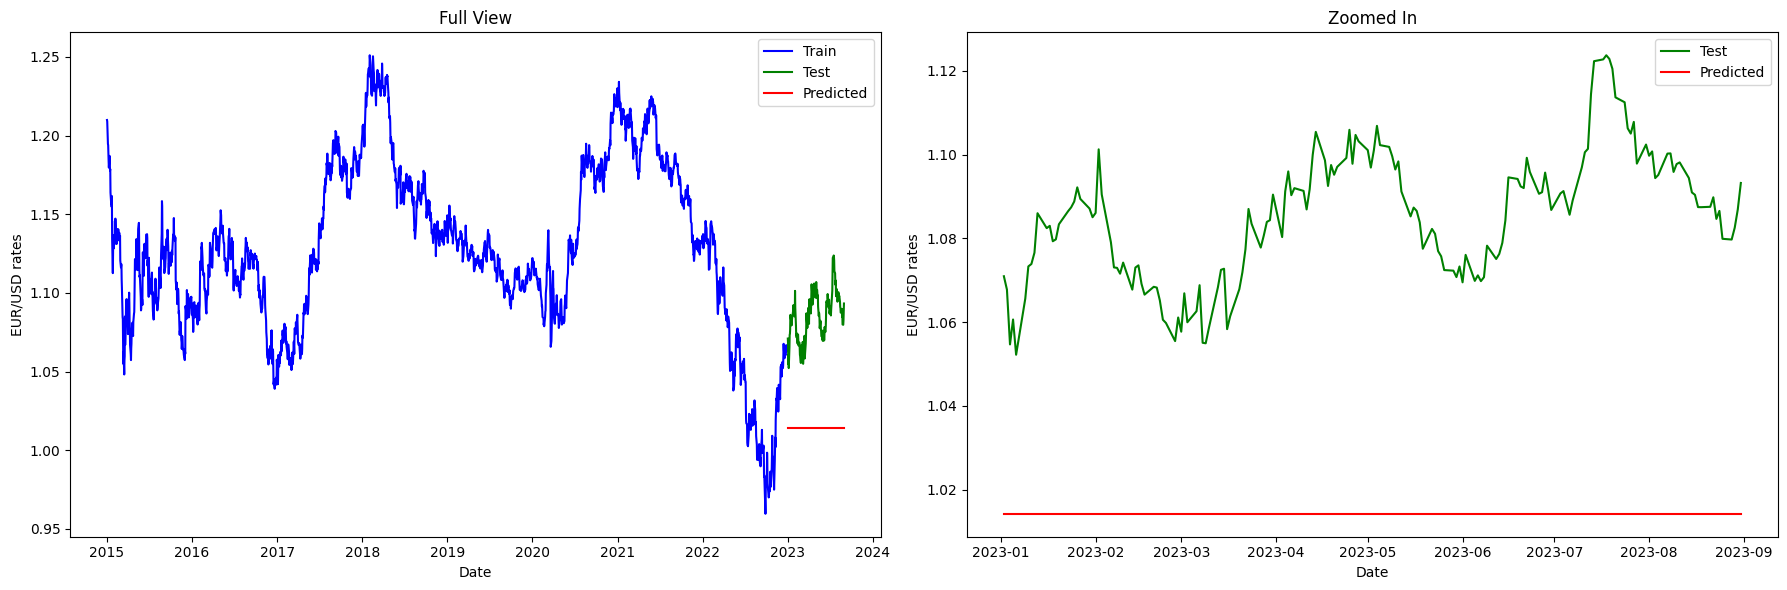

In [ ]:
# plotting the predictions
plot_predictions('pred_last_six_mean')

The past 6 months data makes the predictions worse.

### Developing forecasts using past month's mean

In [ ]:
# Getting the 6 month time interval
last_month_date = np.max(train.index) - np.timedelta64(1, 'M')

# previous year's data
last_month_data = train[train.index >= last_month_date]

# previous year's mean
last_month_mean = last_month_data['Close'].mean()
last_month_mean

1.0571480626645295

In [ ]:
# appending last year's mean to the data
test.loc[:, 'pred_last_month_mean'] = last_month_mean
test.tail()

<ipython-input-37-aa79a96e6d8f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_month_mean'] = last_month_mean


,Close,pred_hist_mean,pred_last_year_mean,pred_last_six_mean,pred_last_month_mean
Date,,,,,
2023-08-25,1.079914,1.128385,1.054269,1.014222,1.057148
2023-08-28,1.079739,1.128385,1.054269,1.014222,1.057148
2023-08-29,1.082556,1.128385,1.054269,1.014222,1.057148
2023-08-30,1.086921,1.128385,1.054269,1.014222,1.057148
2023-08-31,1.093255,1.128385,1.054269,1.014222,1.057148


In [ ]:
mape_last_year_mean = calculate_mape(test['Close'], test['pred_last_month_mean'])
mape_last_year_mean

2.6046977432646603

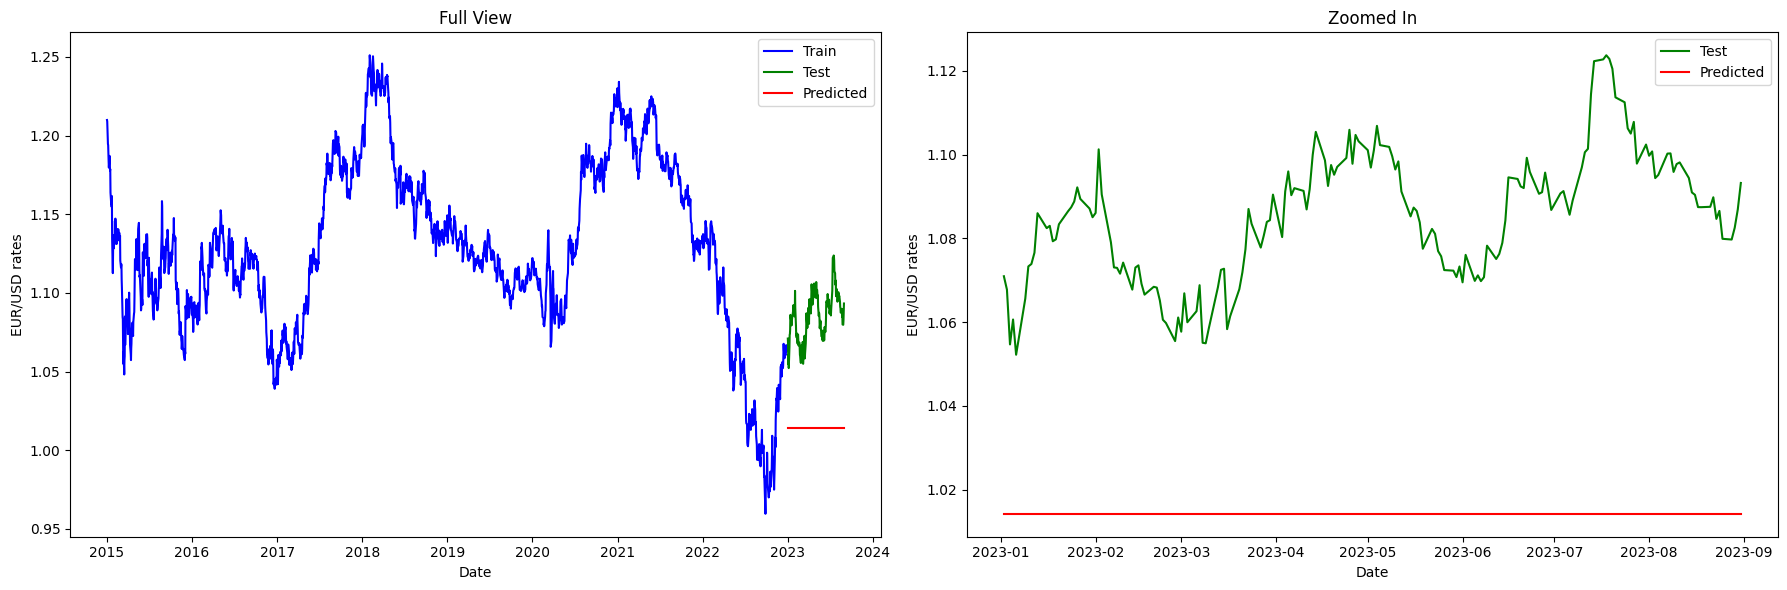

In [ ]:
# plotting the predictions
plot_predictions('pred_last_six_mean')

### Developing forecast using the past week's average

In [ ]:
# Getting the 6 month time interval
last_week_date = np.max(train.index) - np.timedelta64(1, 'W')

# previous year's data
last_week_data = train[train.index >= last_week_date]

# previous year's mean
last_week_mean = last_week_data['Close'].mean()
last_week_mean

1.06397545337677

In [ ]:
# appending last year's mean to the data
test.loc[:, 'pred_last_week_mean'] = last_week_mean
test.tail()

<ipython-input-41-c612c5b46e28>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_week_mean'] = last_week_mean


,Close,pred_hist_mean,pred_last_year_mean,pred_last_six_mean,pred_last_month_mean,pred_last_week_mean
Date,,,,,,
2023-08-25,1.079914,1.128385,1.054269,1.014222,1.057148,1.063975
2023-08-28,1.079739,1.128385,1.054269,1.014222,1.057148,1.063975
2023-08-29,1.082556,1.128385,1.054269,1.014222,1.057148,1.063975
2023-08-30,1.086921,1.128385,1.054269,1.014222,1.057148,1.063975
2023-08-31,1.093255,1.128385,1.054269,1.014222,1.057148,1.063975


In [ ]:
mape_last_year_mean = calculate_mape(test['Close'], test['pred_last_month_mean'])
mape_last_year_mean

2.6046977432646603

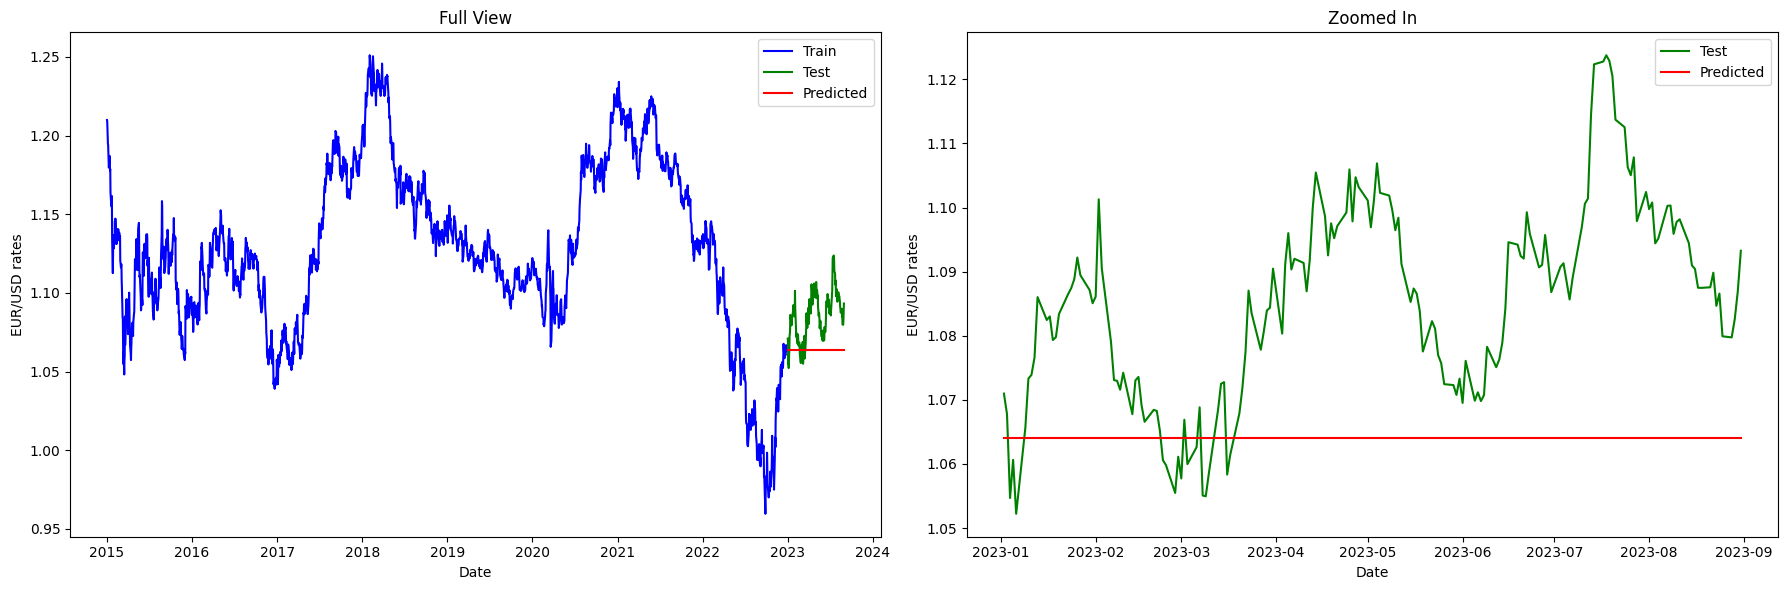

In [ ]:
# plotting the predictions
plot_predictions('pred_last_week_mean')

Notes:

I've reevaluated our approach and found that due to significant data variation, predicting a full year ahead is challenging. To improve accuracy, I suggest training on shorter horizons of one or two years for most models, except for neural networks, which can utilize our extensive dataset. This adjustment should better suit the data's inherent volatility. Then we can try to predict one or 2 weeks ahead.

# Resampling the data and Adjusting the time horizon

We are now only gonna use the past 2 years

In [ ]:
# Limiting the data to the past 2 years interval
new_period = np.max(df.index) - np.timedelta64(2, 'Y')

# previous year's data
df = df[df.index >= new_period]

In [ ]:
# Examining the data
df.shape

(523, 1)

In [ ]:
df.head()

,Close
Date,
2021-08-31,1.179690
2021-09-01,1.181028
2021-09-02,1.184091
2021-09-03,1.187648
2021-09-06,1.188594


In [ ]:
df.tail()

,Close
Date,
2023-08-25,1.079914
2023-08-28,1.079739
2023-08-29,1.082556
2023-08-30,1.086921
2023-08-31,1.093255


In [ ]:
# splitting the data into train and test
test_start_date = df.index.max() - pd.DateOffset(weeks=1)

train = df[df.index < test_start_date]
test = df[test_start_date:]

In [ ]:
train.tail()

,Close
Date,
2023-08-17,1.087488
2023-08-18,1.087465
2023-08-21,1.087559
2023-08-22,1.089835
2023-08-23,1.084669


In [ ]:
test.head(10)

,Close
Date,
2023-08-24,1.086579
2023-08-25,1.079914
2023-08-28,1.079739
2023-08-29,1.082556
2023-08-30,1.086921
2023-08-31,1.093255


## Analyzing the components of the new horizon

<Axes: xlabel='Date'>

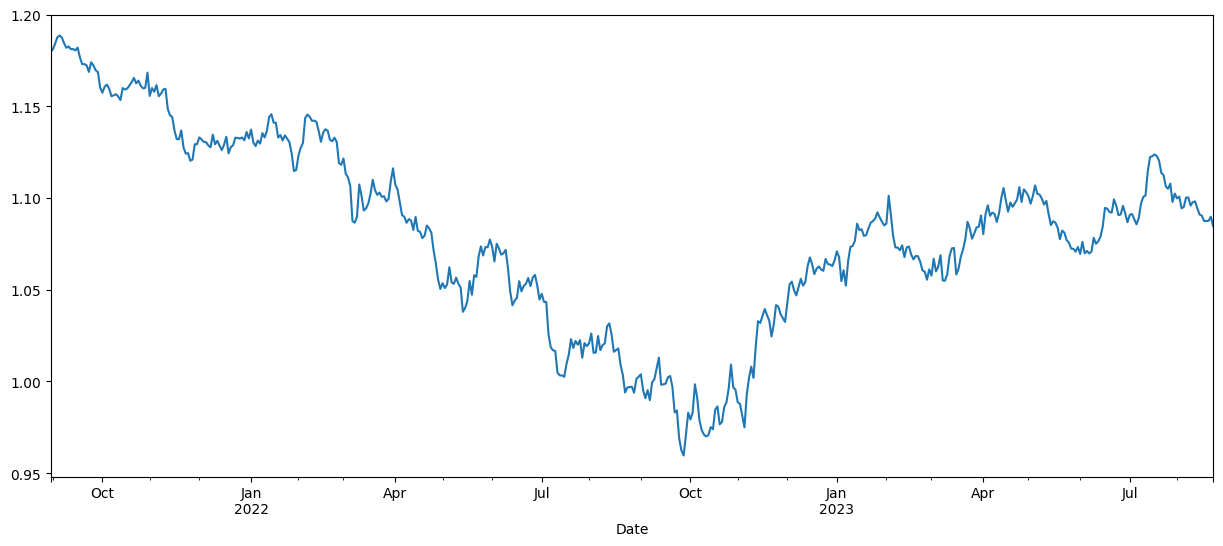

In [ ]:
# let's visualize the dataset
train['Close'].plot(kind='line', figsize=(15,6))

In [ ]:
# decomposing the dataset
advanced_decomposition = STL(df['Close'], period=4).fit()

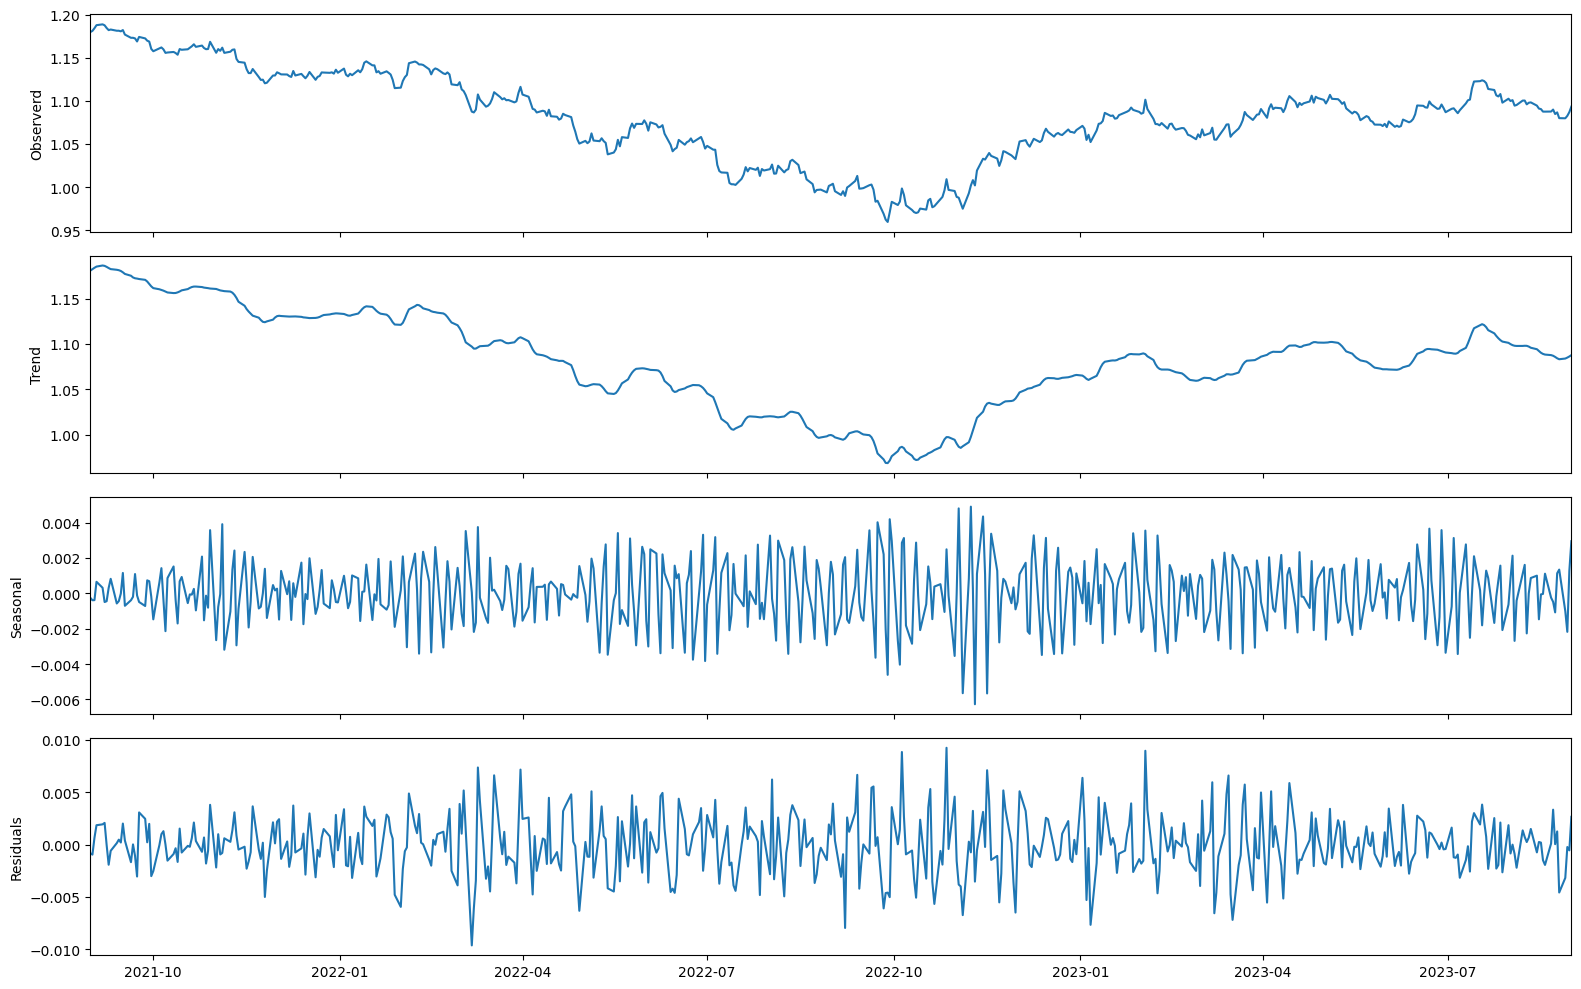

In [ ]:
# viewing the decomposed elements
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(16,10))

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observerd')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlim(df.index[0], df.index[-1])

plt.tight_layout()

We can see much more seasonality and residuals.

## Developing base line models

In [ ]:
def calculate_mae(actual, predicted):
    """
    Calculate the Mean Absolute Error (MAE).

    Parameters:
    actual (array-like): Array of actual values.
    predicted (array-like): Array of predicted values.

    Returns:
    mae (float): Mean Absolute Error.
    """
    mae = mean_absolute_error(actual, predicted)
    return mae

In [ ]:
def calculate_rmse(actual, predicted):
    """
    Calculate the Root Mean Square Error (RMSE).

    Parameters:
    actual (array-like): Array of actual values.
    predicted (array-like): Array of predicted values.

    Returns:
    rmse (float): Root Mean Square Error.
    """
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    return rmse


In [ ]:
import numpy as np

def calculate_smape(y_true, y_pred):
    """
    Calculate the Symmetric Mean Absolute Percentage Error (SMAPE).

    Parameters:
    y_true (array-like): Array of actual (true) values.
    y_pred (array-like): Array of predicted values.

    Returns:
    smape (float): Symmetric Mean Absolute Percentage Error as a percentage.

    Notes:
    SMAPE is a variation of MAPE that symmetrically scales the percentage errors by the sum of the actual and predicted values.
    It is expressed as a percentage and provides a balanced measure of prediction accuracy.
    A lower SMAPE indicates better prediction accuracy.
    """
    absolute_percentage_errors = 2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))
    smape = 100 * np.mean(absolute_percentage_errors)
    return smape

### Using historical mean

In [ ]:
# getting the historical mean of the data
historical_mean = np.mean(train['Close'])
historical_mean

1.0810237623736751

In [ ]:
# adding the historical mean to the test data as a prediction
test.loc[:, 'pred_hist_mean'] = historical_mean
test

<ipython-input-58-1c9056bc4b00>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_hist_mean'] = historical_mean


,Close,pred_hist_mean
Date,,
2023-08-24,1.086579,1.081024
2023-08-25,1.079914,1.081024
2023-08-28,1.079739,1.081024
2023-08-29,1.082556,1.081024
2023-08-30,1.086921,1.081024
2023-08-31,1.093255,1.081024


In [ ]:
# calculating mape
mape_hist_mean = calculate_mape(test['Close'], test['pred_hist_mean'])
mape_hist_mean

0.4226480603024957

In [ ]:
# calculating the mae
mae_hist_mean = calculate_mae(test['Close'], test['pred_hist_mean'])
mae_hist_mean

0.00460171376713477

In [ ]:
# calculating the rmse
rmse_hist_mean = calculate_rmse(test['Close'], test['pred_hist_mean'])
rmse_hist_mean

0.006061642151181173

In [ ]:
# calculating smape
smape_hist_mean = calculate_smape(test['Close'], test['pred_hist_mean'])
smape_hist_mean

0.42415738762670824

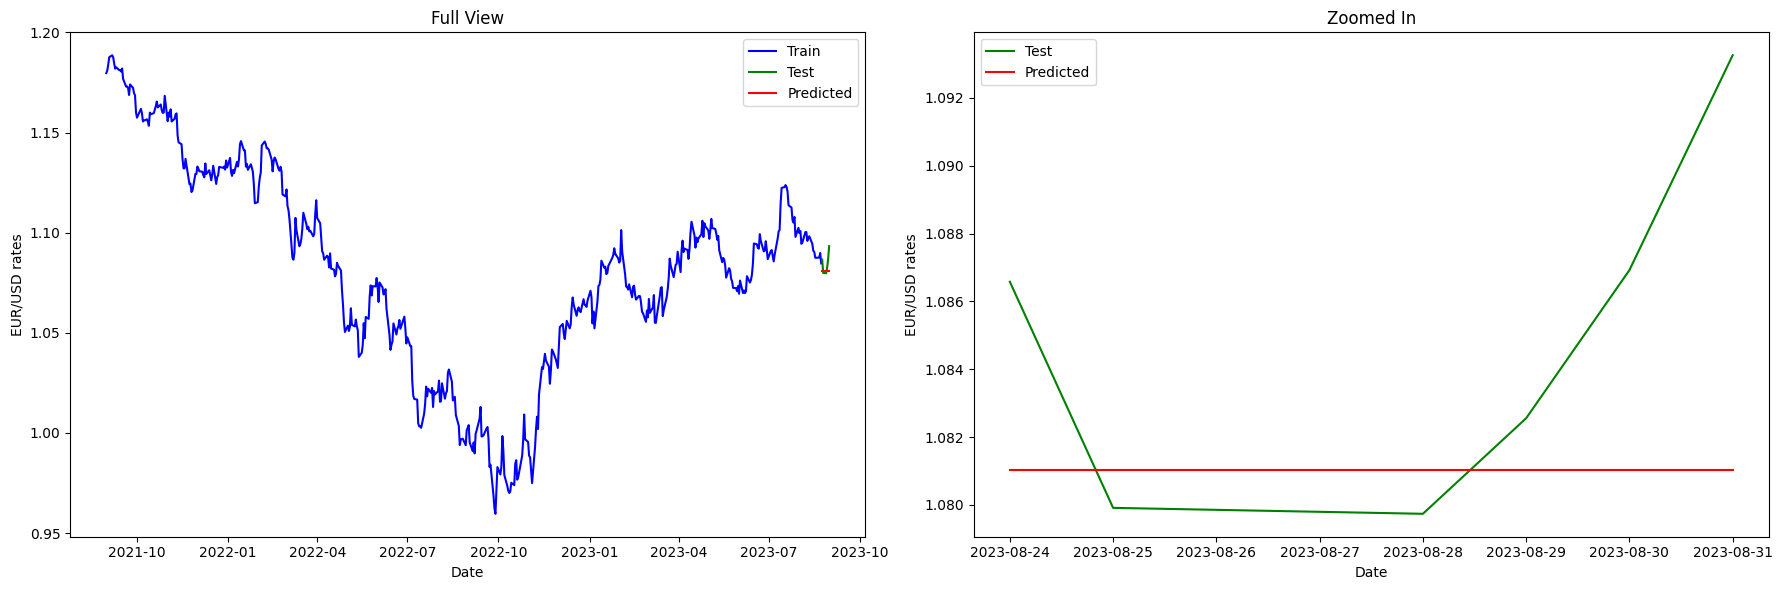

In [ ]:
plot_predictions('pred_hist_mean')

### Using the previous year's mean

In [ ]:
# Getting last year's date
last_year_date = np.max(train.index) - np.timedelta64(1, 'Y')
# last_year_date

# previous year's data
last_year_data = train[train.index >= last_year_date]
# last_year_data.tail()

# previous year's mean
last_year_mean = last_year_data['Close'].mean()
last_year_mean


1.0591752940916832

In [ ]:
# appending last year's mean to the data
test.loc[:, 'pred_last_year_mean'] = last_year_mean
test

<ipython-input-65-7177eb24c0d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_year_mean'] = last_year_mean


,Close,pred_hist_mean,pred_last_year_mean
Date,,,
2023-08-24,1.086579,1.081024,1.059175
2023-08-25,1.079914,1.081024,1.059175
2023-08-28,1.079739,1.081024,1.059175
2023-08-29,1.082556,1.081024,1.059175
2023-08-30,1.086921,1.081024,1.059175
2023-08-31,1.093255,1.081024,1.059175


In [ ]:
mape_last_year_mean = calculate_mape(test['Close'], test['pred_last_year_mean'])
mape_last_year_mean

2.362749754267424

In [ ]:
# calculating the mae
mae_last_year_mean = calculate_mae(test['Close'], test['pred_last_year_mean'])
mae_last_year_mean

0.025651751507936377

In [ ]:
# calculating the rmse
rmse_last_year_mean = calculate_rmse(test['Close'], test['pred_last_year_mean'])
rmse_last_year_mean

0.02608238673314124

In [ ]:
# calculating smape
smape_last_year_mean = calculate_smape(test['Close'], test['pred_last_year_mean'])
smape_last_year_mean

2.391928098840889

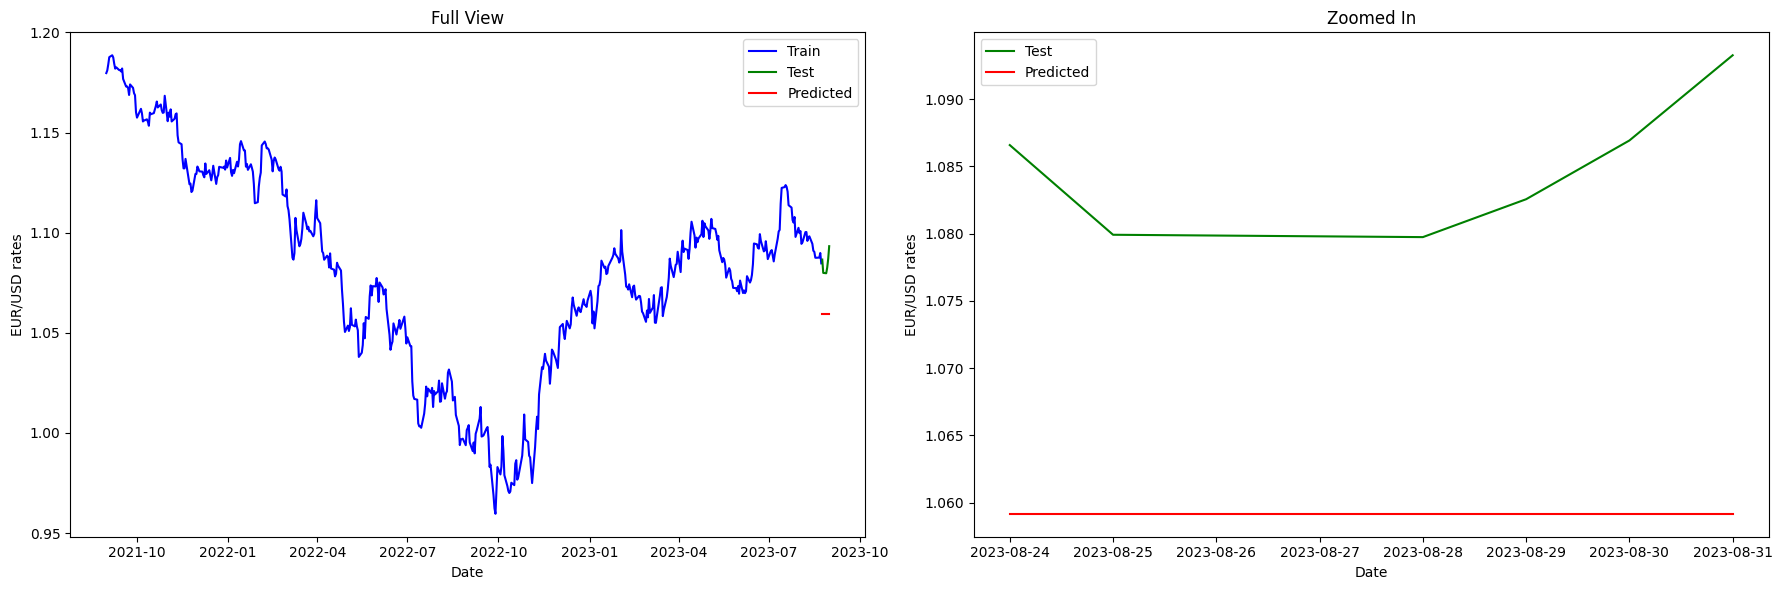

In [ ]:
# plotting the predictions
plot_predictions('pred_last_year_mean')

### Using previous 6 months' average

In [ ]:
# Getting the 6 month time interval
last_sixm_date = np.max(train.index) - np.timedelta64(6, 'M')
# past_six_date

# previous year's data
last_sixm_data = train[train.index >= last_sixm_date]
# past_six_data.tail()

# previous year's mean
pred_last_sixm_mean = last_sixm_data['Close'].mean()
pred_last_sixm_mean

1.0879421161331293

In [ ]:
# appending the past 6 month's mean to the data
test.loc[:, 'pred_last_sixm_mean'] = pred_last_sixm_mean
test

<ipython-input-72-13081d51d905>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_sixm_mean'] = pred_last_sixm_mean


,Close,pred_hist_mean,pred_last_year_mean,pred_last_sixm_mean
Date,,,,
2023-08-24,1.086579,1.081024,1.059175,1.087942
2023-08-25,1.079914,1.081024,1.059175,1.087942
2023-08-28,1.079739,1.081024,1.059175,1.087942
2023-08-29,1.082556,1.081024,1.059175,1.087942
2023-08-30,1.086921,1.081024,1.059175,1.087942
2023-08-31,1.093255,1.081024,1.059175,1.087942


In [ ]:
# calculating mape
mape_last_sixm_mean = calculate_mape(test['Close'], test['pred_last_sixm_mean'])
mape_last_sixm_mean

0.4510232574394657

In [ ]:
# calculating the mae
mae_last_sixm_mean = calculate_mae(test['Close'], test['pred_last_sixm_mean'])
mae_last_sixm_mean

0.004885926956438784

In [ ]:
# calculating the rmse
rmse_last_sixm_mean = calculate_rmse(test['Close'], test['pred_last_sixm_mean'])
rmse_last_sixm_mean

0.00565528131050671

In [ ]:
# calculating smape
smape_last_sixm_mean = calculate_smape(test['Close'], test['pred_last_sixm_mean'])
smape_last_sixm_mean

0.4500561569335657

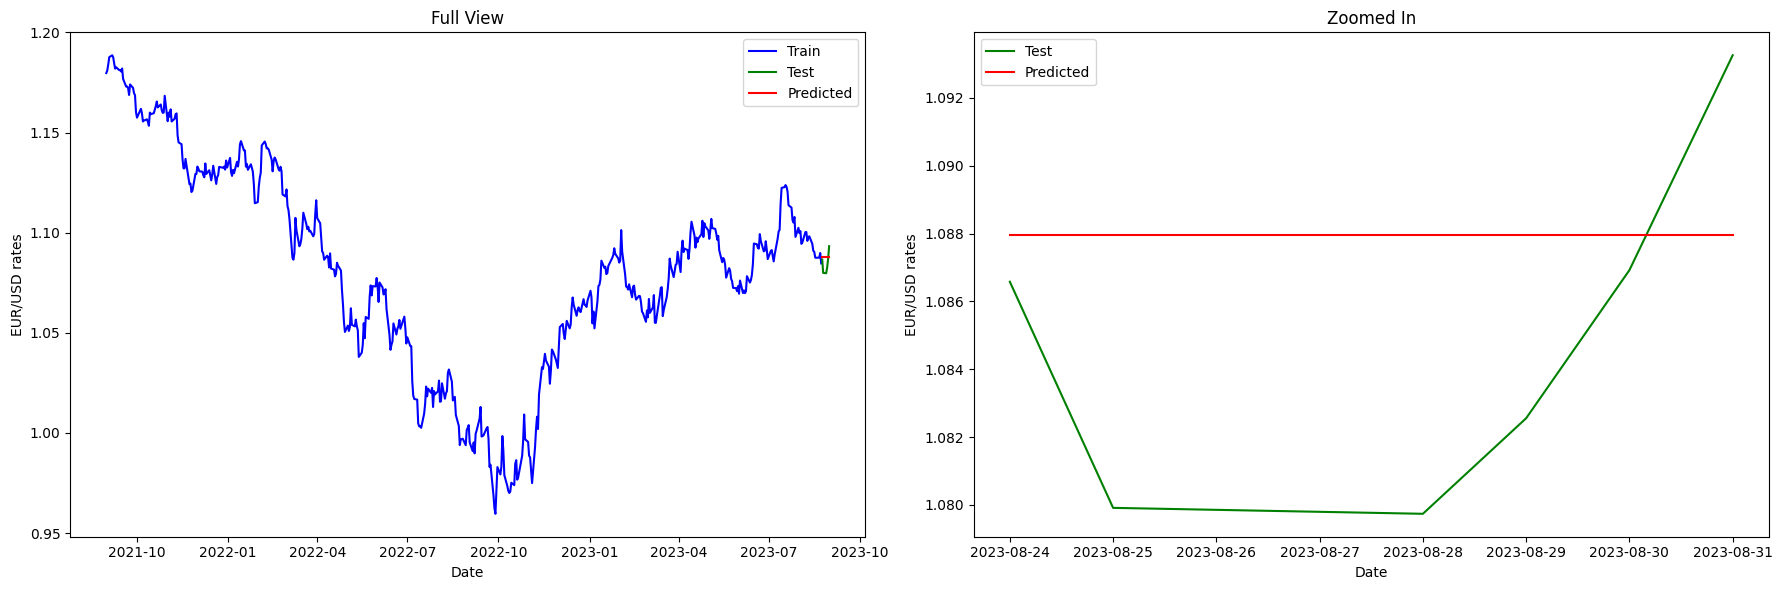

In [ ]:
# plotting the predictions
plot_predictions('pred_last_sixm_mean')

### Using previous month's average


In [ ]:
# Getting the 6 month time interval
last_month_date = np.max(train.index) - np.timedelta64(1, 'M')


# previous year's data
last_month_data = train[train.index >= last_month_date]

# previous year's mean
pred_last_month_mean = last_month_data['Close'].mean()
pred_last_month_mean

1.0968444606532222

In [ ]:
# appending the past 6 month's mean to the data
test.loc[:, 'pred_last_month_mean'] = pred_last_month_mean
test

<ipython-input-79-6eef07876849>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_month_mean'] = pred_last_month_mean


,Close,pred_hist_mean,pred_last_year_mean,pred_last_sixm_mean,pred_last_month_mean
Date,,,,,
2023-08-24,1.086579,1.081024,1.059175,1.087942,1.096844
2023-08-25,1.079914,1.081024,1.059175,1.087942,1.096844
2023-08-28,1.079739,1.081024,1.059175,1.087942,1.096844
2023-08-29,1.082556,1.081024,1.059175,1.087942,1.096844
2023-08-30,1.086921,1.081024,1.059175,1.087942,1.096844
2023-08-31,1.093255,1.081024,1.059175,1.087942,1.096844


In [ ]:
# calculating mape
mape_last_month_mean = calculate_mape(test['Close'], test['pred_last_month_mean'])
mape_last_year_mean

2.362749754267424

In [ ]:
# calculating the mae
mae_last_month_mean = calculate_mae(test['Close'], test['pred_last_month_mean'])
mae_last_month_mean

0.012017415053602579

In [ ]:
# calculating the rmse
rmse_last_month_mean = calculate_rmse(test['Close'], test['pred_last_month_mean'])
rmse_last_month_mean

0.012911111758589184

In [ ]:
# calculating smape
smape_last_month_mean = calculate_smape(test['Close'], test['pred_last_month_mean'])
smape_last_month_mean

1.1026106080655274

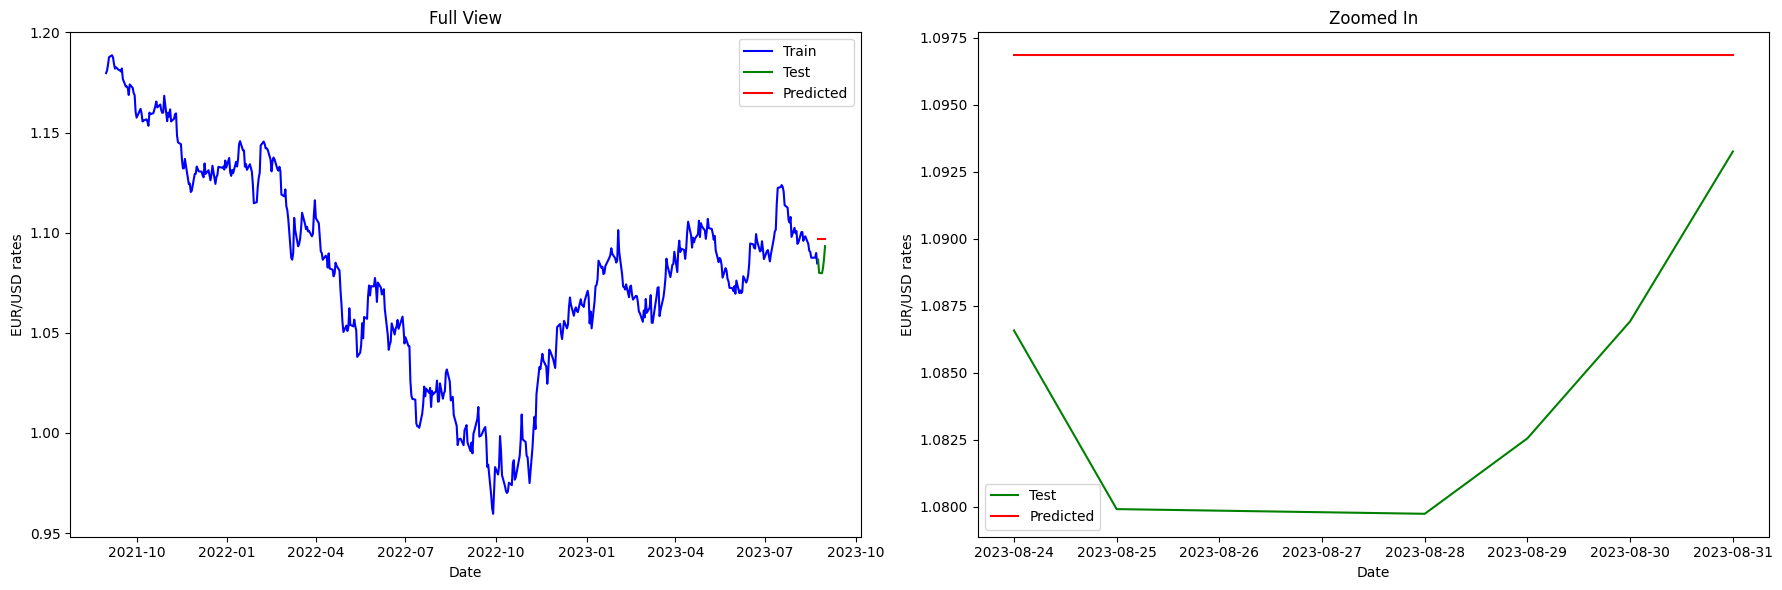

In [ ]:
# plotting the predictions
plot_predictions('pred_last_month_mean')

### Using previous week's average

In [ ]:
# Getting the 6 month time interval
last_week_date = np.max(train.index) - np.timedelta64(1, 'W')

# previous year's data
last_week_data = train[train.index >= last_week_date]

# previous year's mean
last_week_mean = last_week_data['Close'].mean()
last_week_mean

1.087905744711558

In [ ]:
# appending last year's mean to the data
test.loc[:, 'pred_last_week_mean'] = last_week_mean
test

<ipython-input-86-f9e1525526b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_week_mean'] = last_week_mean


,Close,pred_hist_mean,pred_last_year_mean,pred_last_sixm_mean,pred_last_month_mean,pred_last_week_mean
Date,,,,,,
2023-08-24,1.086579,1.081024,1.059175,1.087942,1.096844,1.087906
2023-08-25,1.079914,1.081024,1.059175,1.087942,1.096844,1.087906
2023-08-28,1.079739,1.081024,1.059175,1.087942,1.096844,1.087906
2023-08-29,1.082556,1.081024,1.059175,1.087942,1.096844,1.087906
2023-08-30,1.086921,1.081024,1.059175,1.087942,1.096844,1.087906
2023-08-31,1.093255,1.081024,1.059175,1.087942,1.096844,1.087906


In [ ]:
# calculating mape
mape_last_week_mean = calculate_mape(test['Close'], test['pred_last_week_mean'])
mape_last_week_mean

0.4487794195009259

In [ ]:
# calculating the mae
mae_last_week_mean = calculate_mae(test['Close'], test['pred_last_week_mean'])
mae_last_week_mean

0.0048616793420579825

In [ ]:
# calculating the rmse
rmse_last_week_mean = calculate_rmse(test['Close'], test['pred_last_week_mean'])
rmse_last_week_mean

0.005635328783139186

In [ ]:
# calculating smape
smape_last_week_mean = calculate_smape(test['Close'], test['pred_last_week_mean'])
smape_last_week_mean

0.447827376040158

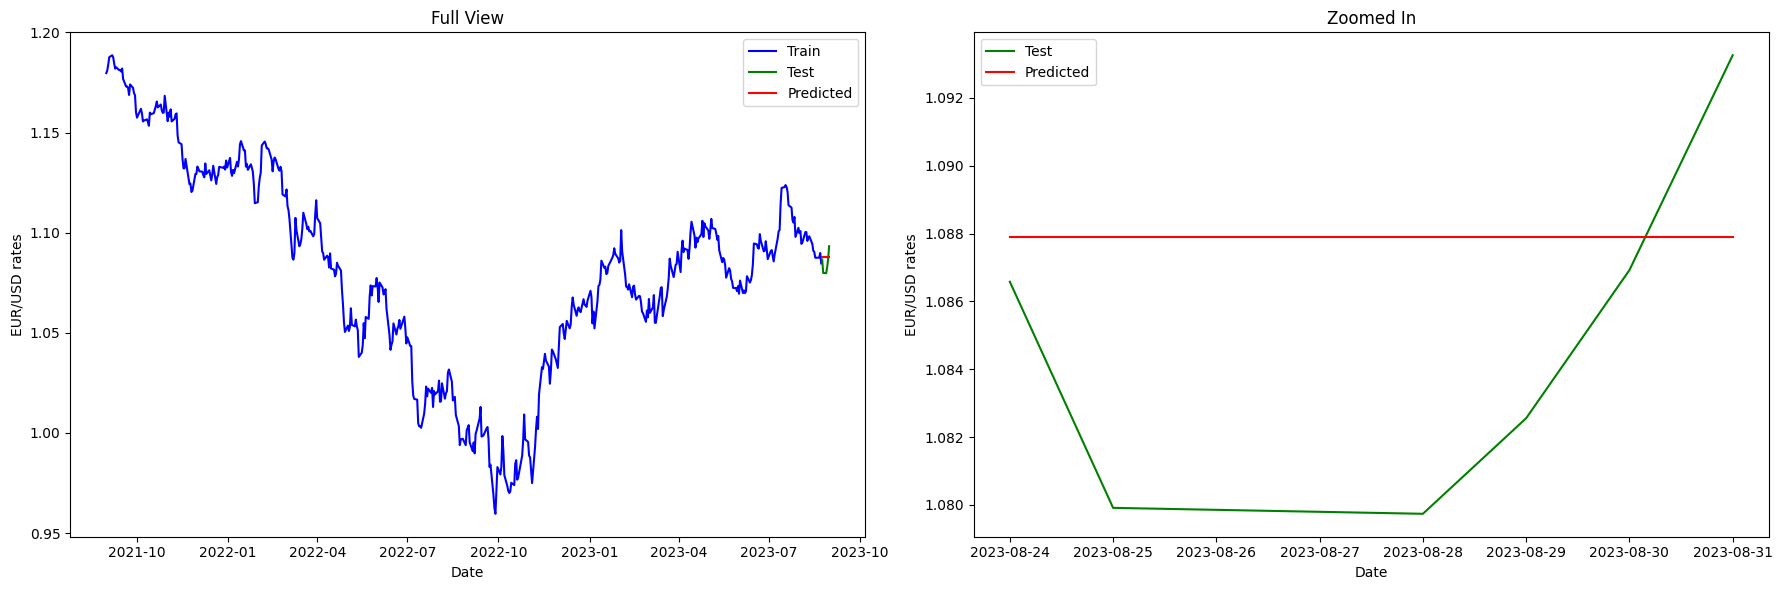

In [ ]:
# plotting the predictions
plot_predictions('pred_last_week_mean')

### Using a naive model

In [ ]:
test.loc[:, 'pred_naive'] = train['Close'][-6:].values
test

<ipython-input-92-796755ff4c63>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_naive'] = train['Close'][-6:].values


,Close,pred_hist_mean,pred_last_year_mean,pred_last_sixm_mean,pred_last_month_mean,pred_last_week_mean,pred_naive
Date,,,,,,,
2023-08-24,1.086579,1.081024,1.059175,1.087942,1.096844,1.087906,1.090417
2023-08-25,1.079914,1.081024,1.059175,1.087942,1.096844,1.087906,1.087488
2023-08-28,1.079739,1.081024,1.059175,1.087942,1.096844,1.087906,1.087465
2023-08-29,1.082556,1.081024,1.059175,1.087942,1.096844,1.087906,1.087559
2023-08-30,1.086921,1.081024,1.059175,1.087942,1.096844,1.087906,1.089835
2023-08-31,1.093255,1.081024,1.059175,1.087942,1.096844,1.087906,1.084669


In [ ]:
# calculating mape
mape_naive = calculate_mape(test['Close'], test['pred_naive'])
mape_naive

0.5476524137499935

In [ ]:
# calculating the mae
mae_naive = calculate_mae(test['Close'], test['pred_naive'])
mae_naive

0.005940516789754195

In [ ]:
# calculating the rmse
rmse_naive = calculate_rmse(test['Close'], test['pred_naive'])
rmse_naive

0.006311995666088948

In [ ]:
# calculating smape
smape_naive = calculate_smape(test['Close'], test['pred_naive'])
smape_naive

0.5469933550001972

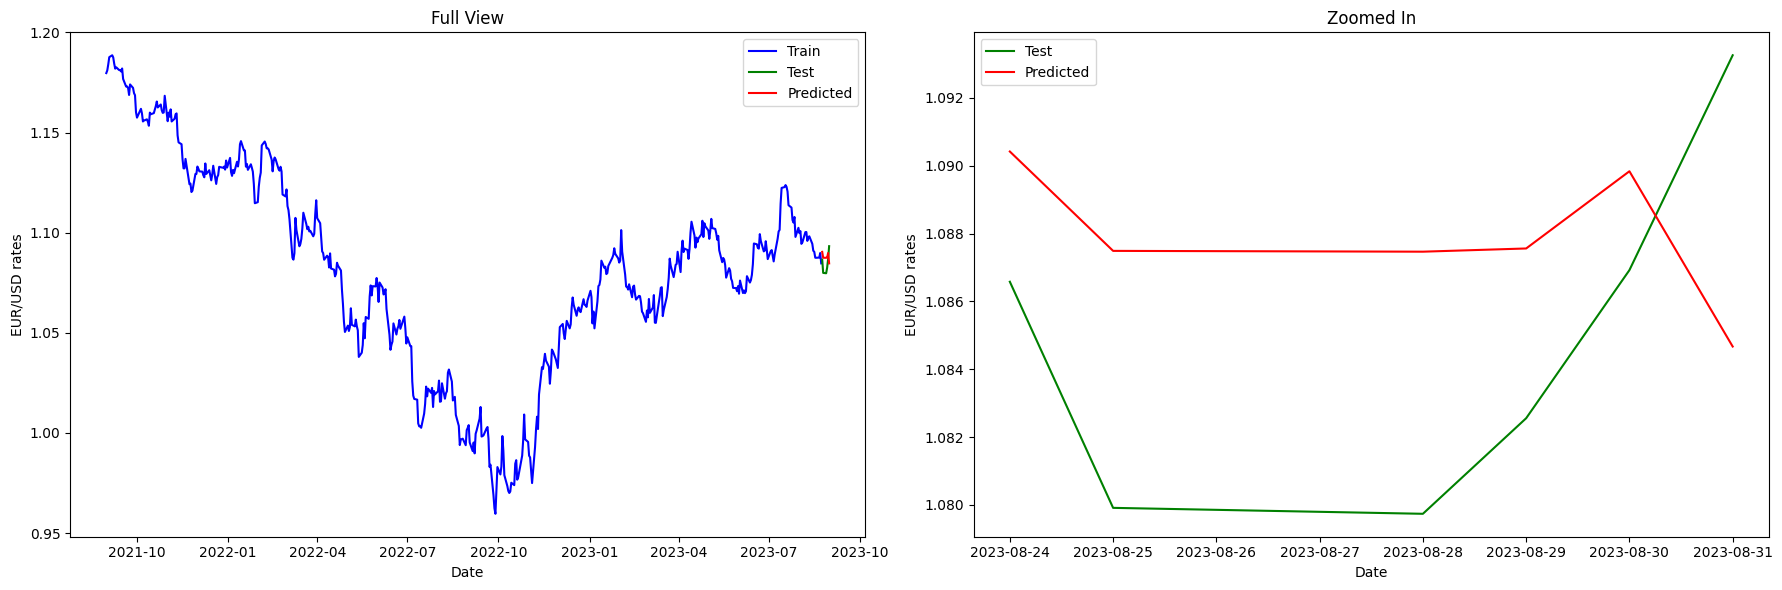

In [ ]:
# plotting the predictions
plot_predictions('pred_naive')

### Assessing the performance of our baselines models

**MAPE**

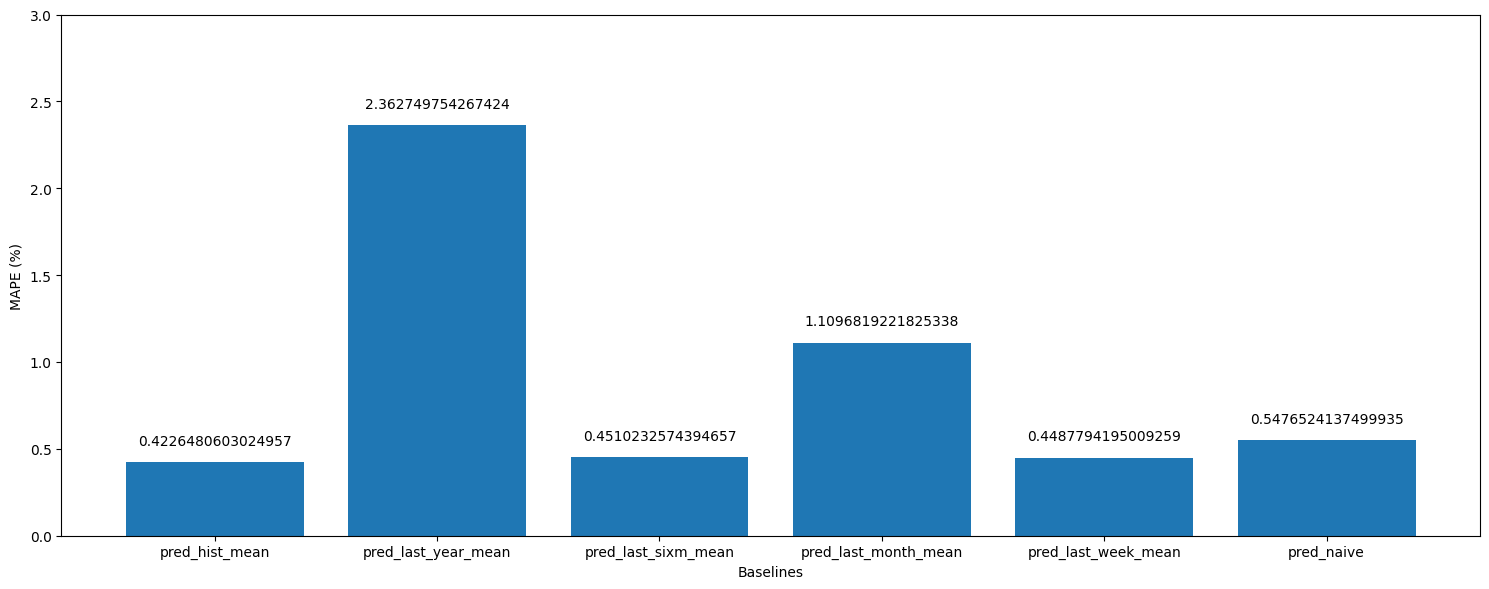

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))

x = ['pred_hist_mean', 'pred_last_year_mean', 'pred_last_sixm_mean', 'pred_last_month_mean', 'pred_last_week_mean', 'pred_naive']
y = [mape_hist_mean,
     mape_last_year_mean,
     mape_last_sixm_mean,
     mape_last_month_mean,
     mape_last_week_mean,
     mape_naive]

ax.bar(x, y)
ax.set_xlabel('Baselines')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0,3)

for index, value in enumerate(y):
  plt.text(x=index, y=value+0.1, s=str(value), ha='center')

plt.tight_layout()

**MAE**

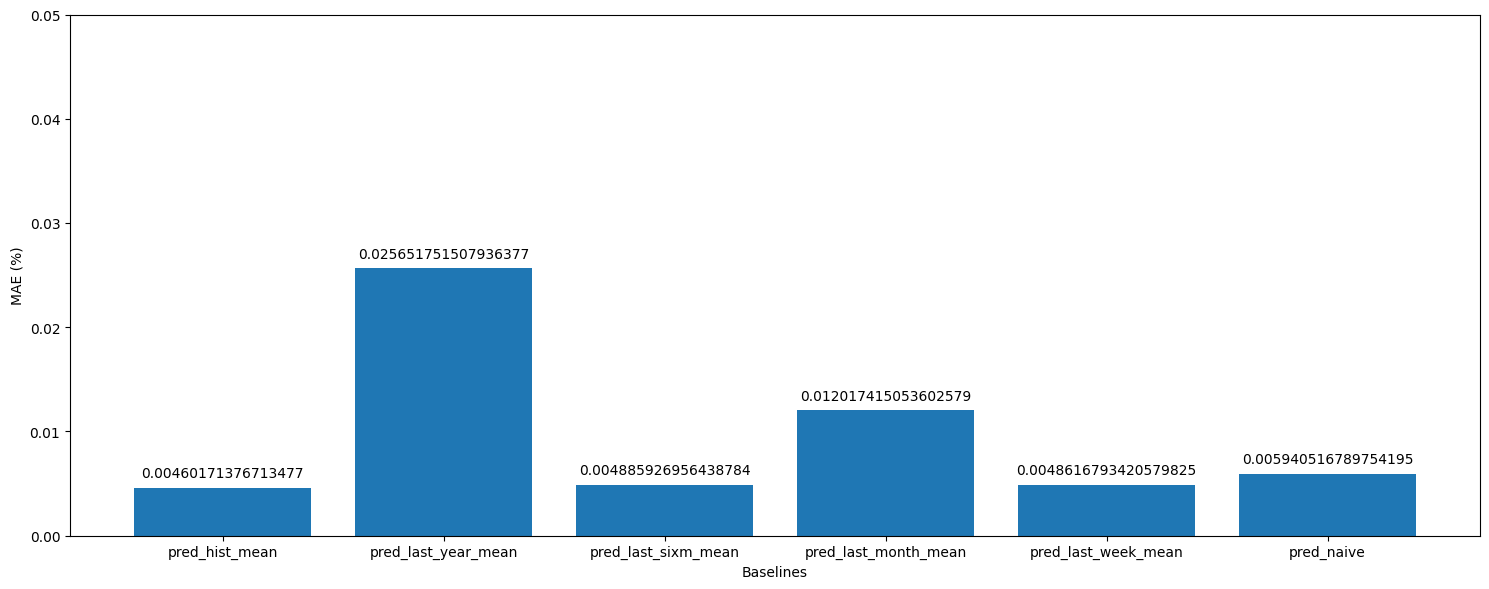

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))

x = ['pred_hist_mean', 'pred_last_year_mean', 'pred_last_sixm_mean', 'pred_last_month_mean', 'pred_last_week_mean', 'pred_naive']
y = [mae_hist_mean,
     mae_last_year_mean,
     mae_last_sixm_mean,
     mae_last_month_mean,
     mae_last_week_mean,
     mae_naive]

ax.bar(x, y)
ax.set_xlabel('Baselines')
ax.set_ylabel('MAE (%)')
ax.set_ylim(0,0.05)

for index, value in enumerate(y):
  plt.text(x=index, y=value+0.001, s=str(value), ha='center')

plt.tight_layout()

**RMSE**

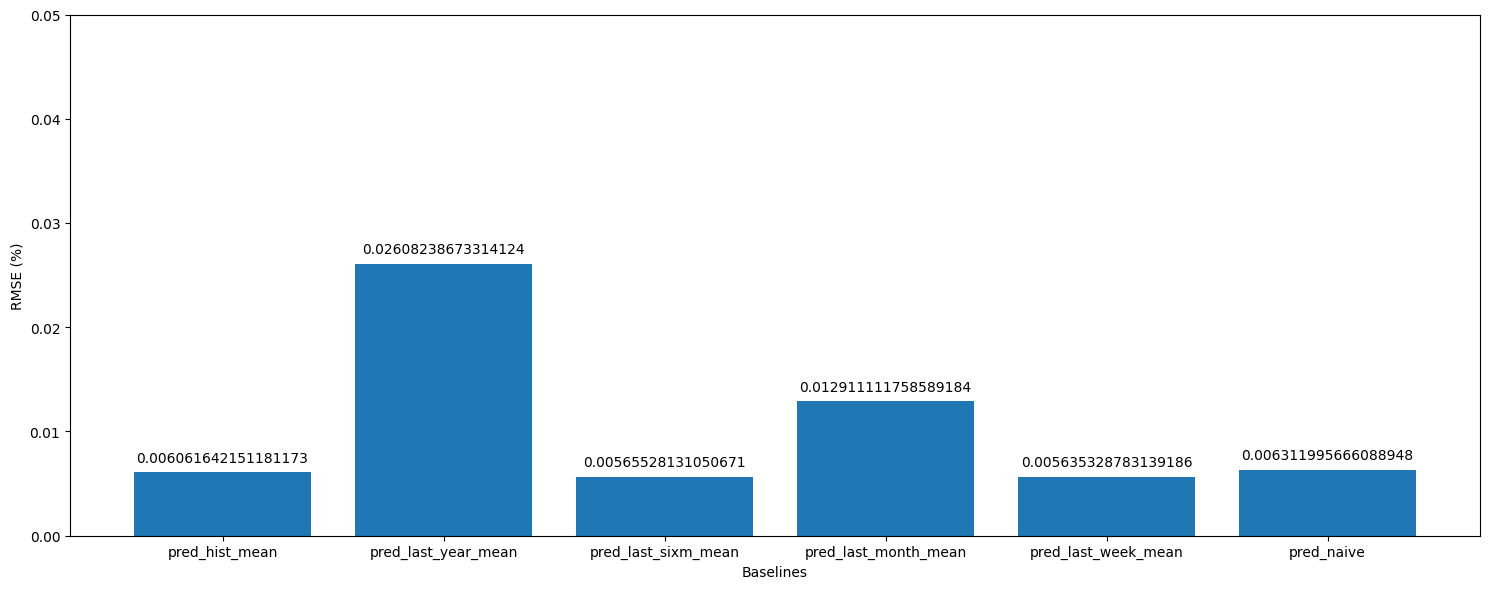

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))

x = ['pred_hist_mean', 'pred_last_year_mean', 'pred_last_sixm_mean', 'pred_last_month_mean', 'pred_last_week_mean', 'pred_naive']
y = [rmse_hist_mean,
     rmse_last_year_mean,
     rmse_last_sixm_mean,
     rmse_last_month_mean,
     rmse_last_week_mean,
     rmse_naive]

ax.bar(x, y)
ax.set_xlabel('Baselines')
ax.set_ylabel('RMSE (%)')
ax.set_ylim(0,0.05)

for index, value in enumerate(y):
  plt.text(x=index, y=value+0.001, s=str(value), ha='center')

plt.tight_layout()

**SMAPE**

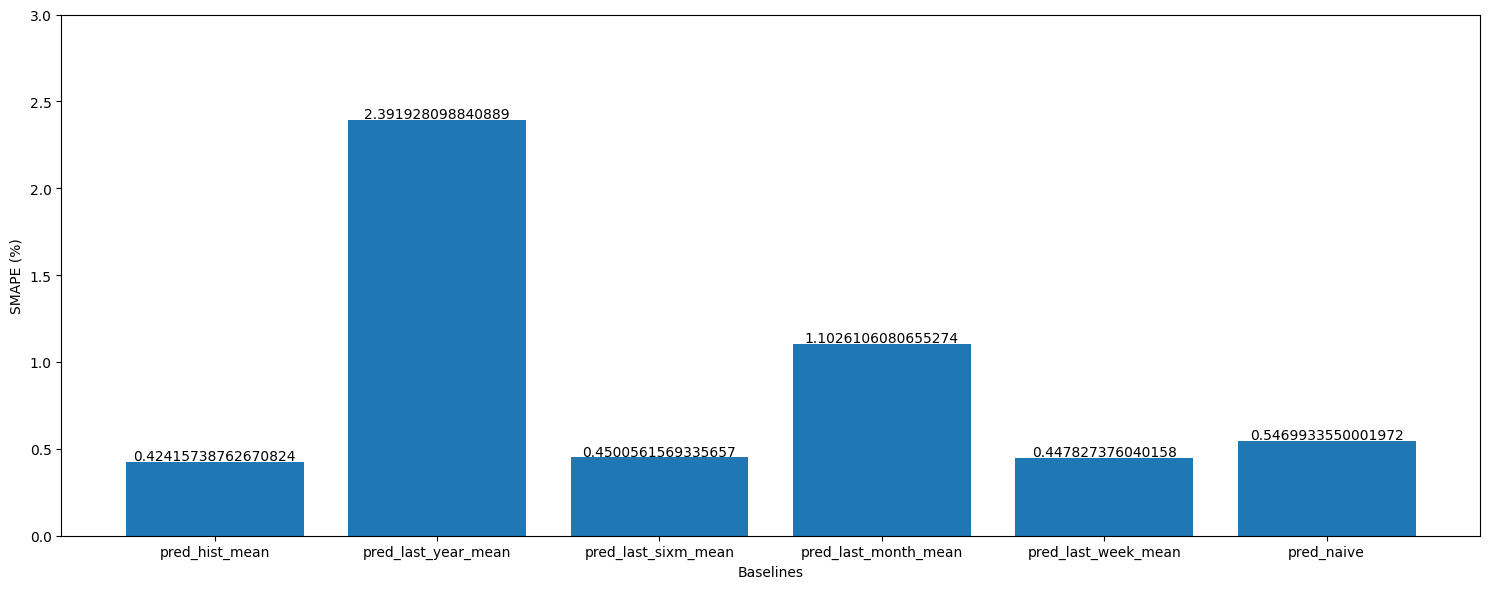

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))

x = ['pred_hist_mean', 'pred_last_year_mean', 'pred_last_sixm_mean', 'pred_last_month_mean', 'pred_last_week_mean', 'pred_naive']
y = [smape_hist_mean,
     smape_last_year_mean,
     smape_last_sixm_mean,
     smape_last_month_mean,
     smape_last_week_mean,
     smape_naive]

ax.bar(x, y)
ax.set_xlabel('Baselines')
ax.set_ylabel('SMAPE (%)')
ax.set_ylim(0,3)

for index, value in enumerate(y):
  plt.text(x=index, y=value+0.01, s=str(value), ha='center')

plt.tight_layout()

Consistently, utilizing data from the previous week or the previous six months results in the lowest prediction errors.

## Testing for stationarity



We will be testing for stationarity using the Dickey-Fuller (ADF) test.

H0: The data is stationary

H1: The data is non-stationary

We will use a p-value of 0.05

In [ ]:
def perform_adf_test(data, label):
    from statsmodels.tsa.stattools import adfuller
    """
    Perform Augmented Dickey-Fuller (ADF) test to check the stationarity of a time series.

    Parameters:
    data (array-like): Time series data for ADF test.
    label (str): Label to identify the data being tested.

    Returns:
    None

    Prints the ADF Statistic, p-value, and the stationarity result for the time series data.

    Notes:
    The ADF test is used to assess whether a time series is stationary or non-stationary.
    - ADF Statistic: The test statistic.
    - p-value: The probability of obtaining the ADF Statistic under the null hypothesis.
    - If p-value <= 0.05, the series is considered stationary (reject null hypothesis).
    - If p-value > 0.05, the series is considered non-stationary (fail to reject null hypothesis).
    """
    result = adfuller(data)
    print(f"{label} ADF Statistic:", result[0])
    print(f"{label} p-value:", result[1])
    if result[1] <= 0.05:
        print(f"{label} is stationary (reject null hypothesis)")
    else:
        print(f"{label} is non-stationary (fail to reject null hypothesis)")

In [ ]:
# initial adf test
perform_adf_test(train['Close'],'Close')

Close ADF Statistic: -1.982411326495426
Close p-value: 0.29433796680063484
Close is non-stationary (fail to reject null hypothesis)


In [ ]:
# differencing the data to make it stationary
differenced_data = train['Close'].diff().dropna()

In [ ]:
# check for stationarity
perform_adf_test(differenced_data, 'Differentiated Close')

Differentiated Close ADF Statistic: -22.13856033115285
Differentiated Close p-value: 0.0
Differentiated Close is stationary (reject null hypothesis)


## Testing for autocorelation

In [ ]:
# importing the necessary package
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

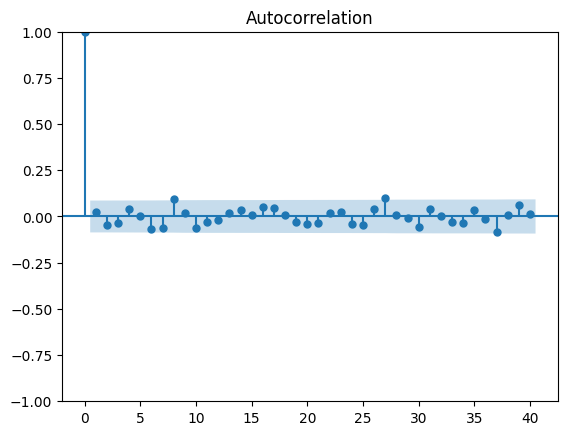

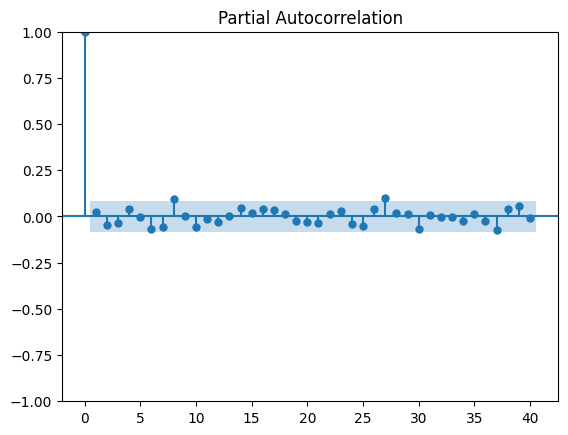

In [ ]:
# checking the autocorelation for the stationary data
plot_acf(differenced_data.dropna(), lags=40)
plot_pacf(differenced_data.dropna().dropna(), lags=40)
plt.show()

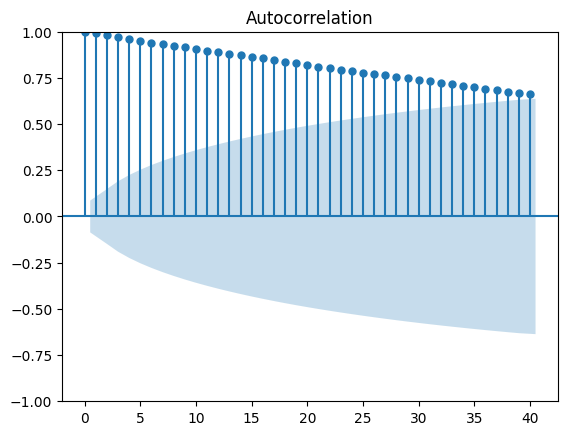

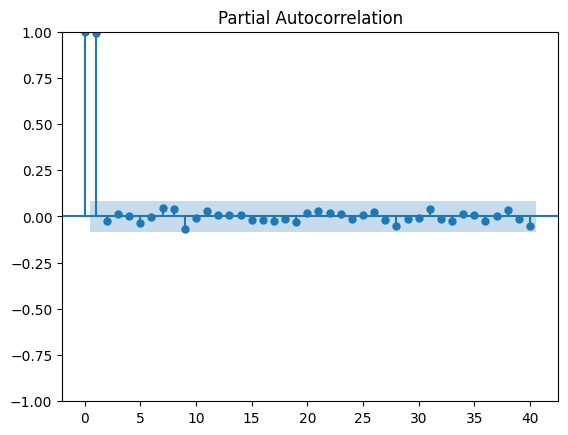

In [ ]:
# checking the acf and pacf for the non-stationary data
plot_acf(train['Close'].dropna(), lags=40)
plot_pacf(train['Close'].dropna(), lags=40)
plt.show()

Comparing the AutoCorrelation Function (ACF) and the Partial AutoCorrelation Function (PACF) between the stationary and non-stationary data reveals a key insight. In the presence of non-stationarity, it appears that traditional differencing alone may not suffice. When analyzing the decomposition components, it becomes evident that the trend component holds significant information. Differencing, which effectively eliminates trends, leaves us with what appears to be random noise.

As a result, it is crucial to consider modeling approaches that can accommodate non-stationarity. Failure to do so may lead to a model resembling a random walk. Given the prominence of the trend component in our data, it is essential to explore models that explicitly capture trends and seasonality, allowing us to harness the valuable patterns within the data.

# Modeling
The modeling methods I want to use are:
1. ARIMA models and varitions(SARIMA, SARIMAX)
2. Exponential smoothing models
3. Prophet
4. Neural Net

## ARIMA

We know that the data is not stationary so an ARIMA model might be good.

In [ ]:
# stationary test
perform_adf_test(train['Close'], 'Close')

Close ADF Statistic: -1.982411326495426
Close p-value: 0.29433796680063484
Close is non-stationary (fail to reject null hypothesis)


We need to set the order of integration d which is the number of differences before the data is stationary. As shown below, a first order difference is enough to make our model stationary.

In [ ]:
# differencing the data
differenced_data = train['Close'].diff().dropna()

In [ ]:
# check for stationarity
perform_adf_test(differenced_data, 'Differentiated Close')

Differentiated Close ADF Statistic: -22.13856033115285
Differentiated Close p-value: 0.0
Differentiated Close is stationary (reject null hypothesis)


This shows that *d = 1*

In [ ]:
# importing the necessary packages
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    """
    Optimize ARIMA model parameters to find the best configuration based on AIC.

    Parameters:
    - endog (Union[pd.Series, list]): Time series data to be modeled.
    - order_list (list): List of (p, q) parameter combinations to be tested.
    - d (int): Order of integration for making data stationary.

    Returns:
    - result_df (pd.DataFrame): DataFrame containing AIC values for each parameter combination sorted in ascending order.

    The function fits ARIMA models with different (p, q) parameter combinations and selects the configuration that minimizes the AIC value. The AIC value measures the model's goodness of fit, with lower values indicating better models.
    """

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=False).reset_index(drop=True)

    return result_df


In [ ]:
# setting the p and q parameters
ps = range(0,10,1)
qs = range(0,10,1)
d = 1

order_list = list(product(ps, qs))

In [ ]:
result_df = optimize_ARIMA(train['Close'], order_list, d)
result_df

  0%|          | 0/100 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(9, 9)",-3845.862661
1,"(9, 8)",-3847.859265
2,"(8, 9)",-3847.864056
3,"(8, 8)",-3848.193276
4,"(7, 9)",-3849.673793
...,...,...
95,"(0, 2)",-3867.928832
96,"(2, 0)",-3868.068325
97,"(1, 0)",-3869.048161
98,"(0, 1)",-3869.068985


In [ ]:
# fitting the model
model = SARIMAX(train['Close'], order=(9,1,9), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  517
Model:               SARIMAX(9, 1, 9)   Log Likelihood                1941.931
Date:                Fri, 13 Oct 2023   AIC                          -3845.863
Time:                        13:44:47   BIC                          -3765.187
Sample:                    08-31-2021   HQIC                         -3814.248
                         - 08-23-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0135      0.169      0.080      0.936      -0.317       0.344
ar.L2         -0.0125      1.422     -0.009      0.993      -2.800       2.775
ar.L3         -0.0172      1.067     -0.016      0.9

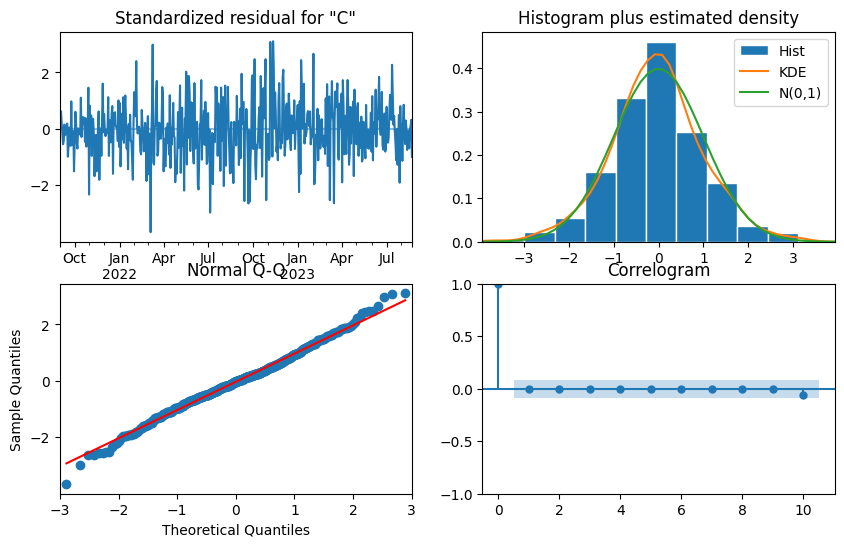

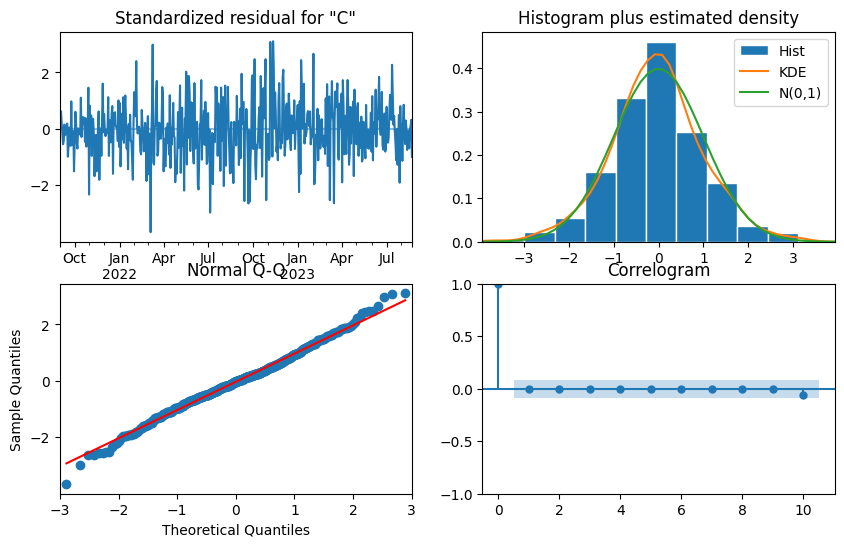

In [ ]:
# checking diagnostics
model_fit.plot_diagnostics(figsize=(10, 6))

In [ ]:
# making predictions
ARIMA_pred = model_fit.forecast(steps=len(test))

In [ ]:
# adding the predictions to the test data frame
test['ARIMA_pred'] = ARIMA_pred
test

,Close,pred_hist_mean,pred_last_year_mean,pred_last_sixm_mean,pred_last_month_mean,pred_last_week_mean,pred_naive,ARIMA_pred
Date,,,,,,,,
2023-08-24,1.086579,1.081024,1.059175,1.087942,1.096844,1.087906,1.090417,1.084318
2023-08-25,1.079914,1.081024,1.059175,1.087942,1.096844,1.087906,1.087488,1.084336
2023-08-28,1.079739,1.081024,1.059175,1.087942,1.096844,1.087906,1.087465,1.084730
2023-08-29,1.082556,1.081024,1.059175,1.087942,1.096844,1.087906,1.087559,1.084225
2023-08-30,1.086921,1.081024,1.059175,1.087942,1.096844,1.087906,1.089835,1.084028
2023-08-31,1.093255,1.081024,1.059175,1.087942,1.096844,1.087906,1.084669,1.084270


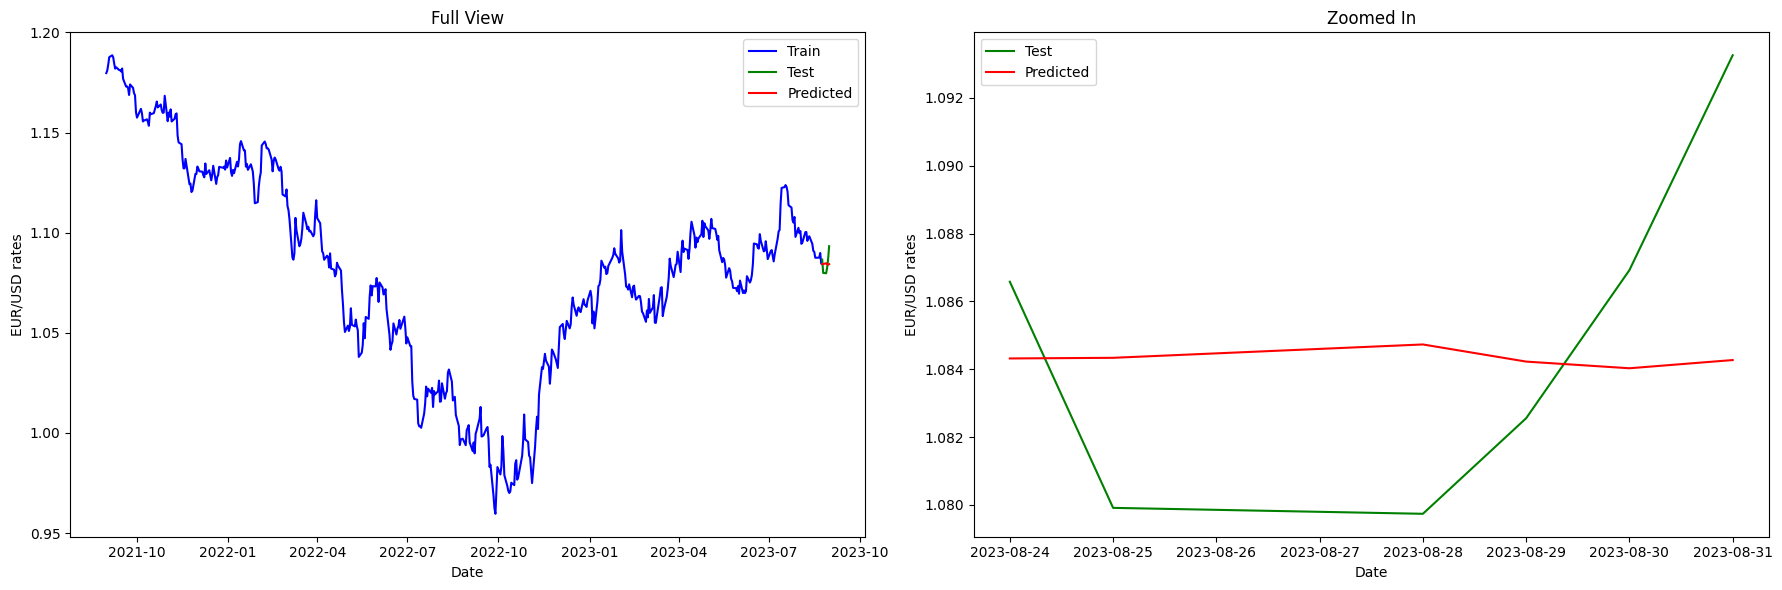

In [ ]:
# visualizing the prediction
plot_predictions('ARIMA_pred')

In [ ]:
# calculating mape
mape_ARIMA = calculate_mape(test['Close'],ARIMA_pred)
mape_ARIMA

0.38700859488239264

In [ ]:
# calculating the mae
mae_ARIMA = calculate_mae(test['Close'],ARIMA_pred)
mae_ARIMA

0.004203594977526685

In [ ]:
# calculating the rmse
rmse_ARIMA = calculate_rmse(test['Close'],ARIMA_pred)
rmse_ARIMA

0.004855566773509893

In [ ]:
# calculating smape
smape_ARIMA = calculate_smape(test['Close'],ARIMA_pred)
smape_ARIMA

0.38733194801959625

## SARIMA

We already know from above that d=1.

In [ ]:
from typing import Union
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook

def optimize_SARIMA(
    endog: Union[pd.Series, list],
    order_list: list,
    d: int,
    D: int,
    s: int
) -> pd.DataFrame:
    """
    Optimize Seasonal ARIMA (SARIMA) model parameters to find the best configuration based on AIC.

    Parameters:
    - endog (Union[pd.Series, list]): Time series data to be modeled.
    - order_list (list): List of (p, q, P, Q) parameter combinations to be tested.
    - d (int): Order of integration for making data stationary.
    - D (int): Seasonal order of integration.
    - s (int): Seasonal period.

    Returns:
    - result_df (pd.DataFrame): DataFrame containing AIC values for each parameter combination sorted in ascending order.

    The function fits SARIMA models with different (p, q, P, Q) parameter combinations and selects the configuration that minimizes the AIC value. The AIC value measures the model's goodness of fit, with lower values indicating better models.
    """

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False
            ).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    # Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=False).reset_index(drop=True)

    return result_df


In [ ]:
# finding parameters for ARIMA model
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = [0]
Qs = [0]

d = 1
D = 0
s = 7

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

ARIMA_result_df = optimize_SARIMA(train['Close'], ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",-3858.773265
1,"(2, 3, 0, 0)",-3860.773236
2,"(3, 2, 0, 0)",-3862.509563
3,"(2, 2, 0, 0)",-3862.773280
4,"(1, 3, 0, 0)",-3864.214445
5,"(3, 1, 0, 0)",-3864.600782
6,"(1, 2, 0, 0)",-3865.906236
7,"(2, 1, 0, 0)",-3865.944187
8,"(3, 0, 0, 0)",-3866.585899
9,"(0, 3, 0, 0)",-3866.594727


In [ ]:
# finding the parameters for the SARIMA model
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 7

SARIMA_result_df = optimize_SARIMA(train['Close'], SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",-3416.878351
1,"(3, 2, 0, 0)",-3420.428252
2,"(2, 3, 0, 0)",-3420.465847
3,"(1, 3, 0, 0)",-3420.877960
4,"(2, 2, 0, 0)",-3422.199269
...,...,...
251,"(1, 0, 0, 3)",-3778.921807
252,"(0, 1, 0, 2)",-3780.512558
253,"(0, 0, 0, 3)",-3780.746201
254,"(0, 0, 1, 1)",-3782.486871


In [ ]:
SARIMA_model = SARIMAX(train, order=(3,1,3), seasonal_order=(0,1,0,7), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  517
Model:             SARIMAX(3, 1, 3)x(0, 1, [], 7)   Log Likelihood                1715.439
Date:                            Fri, 13 Oct 2023   AIC                          -3416.878
Time:                                    14:16:40   BIC                          -3387.251
Sample:                                08-31-2021   HQIC                         -3405.262
                                     - 08-23-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       9.905e-07      0.021   4.66e-05      1.000      -0.042       0.042
ar.L2      -7.391e-06      0.021   

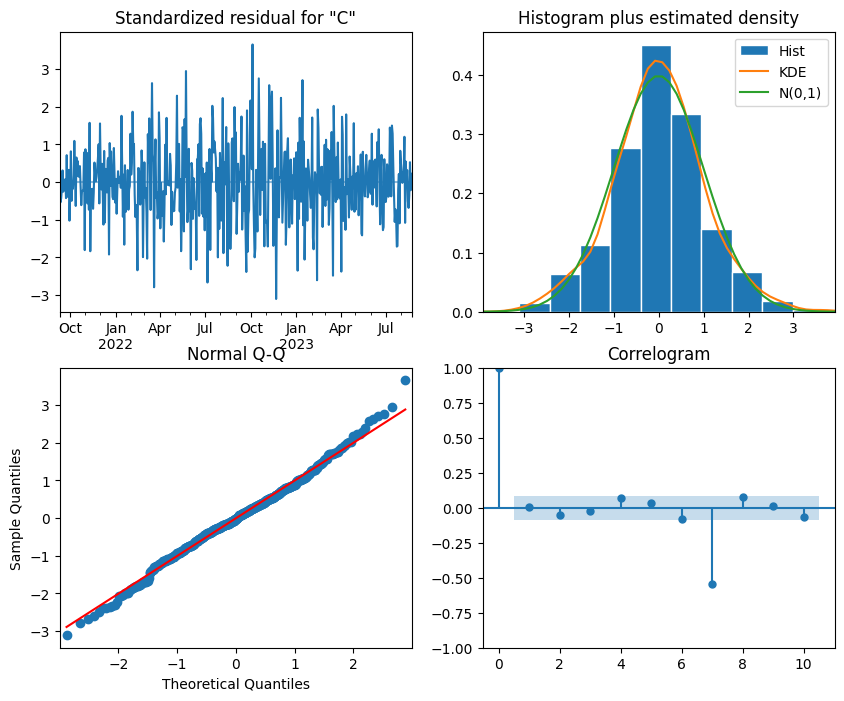

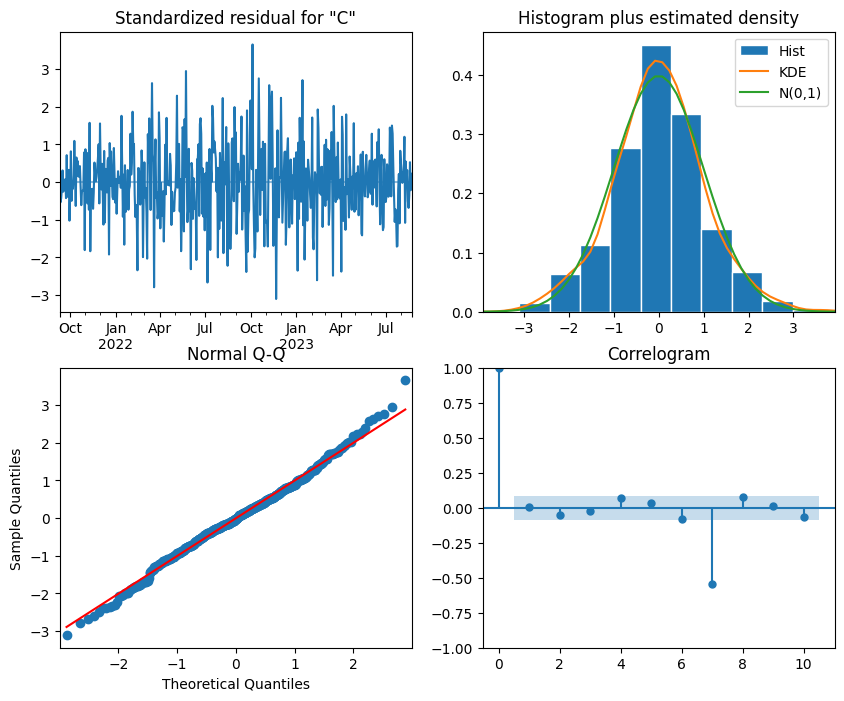

In [ ]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [ ]:
# making predictions
SARIMA_pred = SARIMA_model_fit.forecast(steps=len(test))

In [ ]:
# adding the predictions to the test data frame
test['SARIMA_pred'] = SARIMA_pred
test

,Close,pred_hist_mean,pred_last_year_mean,pred_last_sixm_mean,pred_last_month_mean,pred_last_week_mean,pred_naive,ARIMA_pred,SARIMA_pred
Date,,,,,,,,,
2023-08-24,1.086579,1.081024,1.059175,1.087942,1.096844,1.087906,1.090417,1.084318,1.081218
2023-08-25,1.079914,1.081024,1.059175,1.087942,1.096844,1.087906,1.087488,1.084336,1.080647
2023-08-28,1.079739,1.081024,1.059175,1.087942,1.096844,1.087906,1.087465,1.084730,1.077719
2023-08-29,1.082556,1.081024,1.059175,1.087942,1.096844,1.087906,1.087559,1.084225,1.077695
2023-08-30,1.086921,1.081024,1.059175,1.087942,1.096844,1.087906,1.089835,1.084028,1.077790
2023-08-31,1.093255,1.081024,1.059175,1.087942,1.096844,1.087906,1.084669,1.084270,1.080065


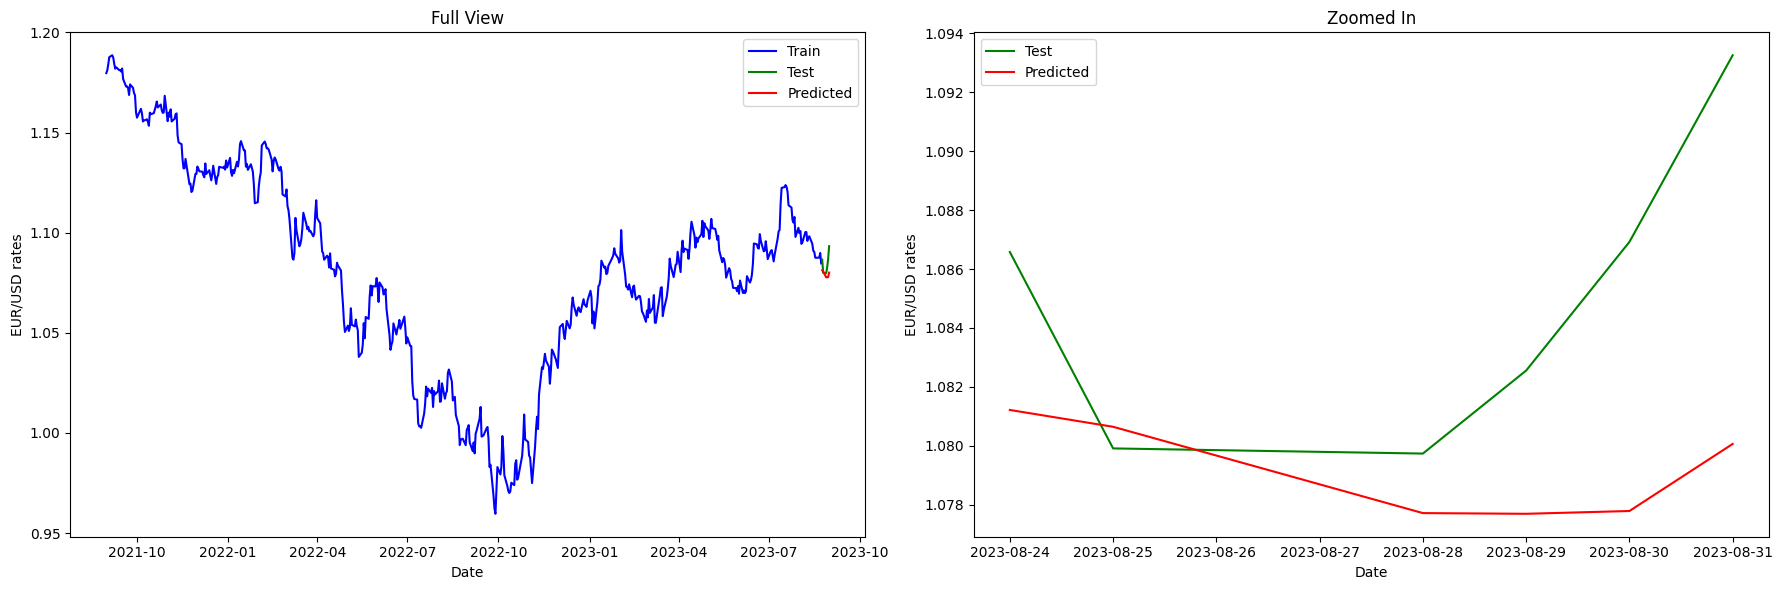

In [ ]:
# visualizing the prediction
plot_predictions('SARIMA_pred')

In [ ]:
# calculating mape
mape_SARIMA = calculate_mape(test['Close'],SARIMA_pred)
mape_SARIMA

0.5406543019311826

In [ ]:
# calculating the mae
mae_SARIMA = calculate_mae(test['Close'],SARIMA_pred)
mae_SARIMA

0.0058826390525274315

In [ ]:
# calculating the rmse
rmse_SARIMA = calculate_rmse(test['Close'],SARIMA_pred)
rmse_SARIMA

0.007237905828158669

In [ ]:
# calculating smape
smape_SARIMA = calculate_smape(test['Close'],SARIMA_pred)
smape_SARIMA

0.5428622616950527

This model appears to follow the shape of the data a little better. This shows that there could be a weekly seasonality element and a trend.